# 📊 STA211 - EDA & Prétraitement des Données

Ce notebook réalise l'analyse exploratoire des données (EDA) ainsi que leur prétraitement, dans le cadre du projet **Internet Advertisements** du module **STA211**.

---

## 🔍 Objectifs :
- **Explorer les caractéristiques du dataset**
  - Dimension des données (nombre de lignes, colonnes)
  - Types de variables (numériques, catégorielles)
  - Distribution des classes (publicité vs non-publicité)
  
- **Analyser la qualité des données**
  - Identifier et traiter les valeurs manquantes
  - Détecter les valeurs aberrantes
  - Vérifier la cohérence des données
  
- **Visualiser les patterns**
  - Distributions des variables
  - Corrélations entre features
  - Analyse des mots-clés les plus discriminants
  
- **Prétraiter les données**
  - Encodage des variables catégorielles
  - Normalisation/Standardisation si nécessaire
  - Feature engineering éventuel
  - Séparation train/test stratifiée

---



In [ ]:
# Métadonnées du projet
PROJECT_NAME = "Projet STA 211: Internet Advertisements Classification"
DATASET_NAME = "Internet Advertisements Dataset"
AUTHOR = "Abdoullatuf"
DATE = "2025-06"
VERSION = "1.0"

# Affichage des informations
print(f"Projet: {PROJECT_NAME}")
print(f"Auteur: {AUTHOR}")
print(f"Version: {VERSION}")

Projet: Internet Advertisements Classification
Auteur: Abdoullatuf
Version: 1.0


# Table des matières
1. [Introduction](#introduction)
2. [Configuration de l'environnement et imports](#configuration-environnement-imports)
    - 2.1 [Configuration de l'environnement](#configuration-environnement)
    - 2.2 [Import des bibliothèques](#import-des-bibliotheques)
    - 2.3 [Configuration des paramètres du projet](#configuration-parametres-projet)
3. [Chargement et aperçu des données](#chargement-et-apercu-des-donnees)
    - 3.1 [Chargement des jeux de données bruts](#chargement-des-jeux-de-donnees-bruts)
    - 3.2 [Inspection des colonnes et types](#inspection-des-colonnes-et-types)
    - 3.3 [Distribution de la variable cible](#distribution-variable-cible)
4. [Analyse exploratoire](#analyse-exploratoire)
    - 4.1 [Analyse des valeurs manquantes](#analyse-des-valeurs-manquantes)
    - 4.2 [Analyse statistique des variables quantitatives](#analyse-statistique-des-variables-quantitatives)
    - 4.3 [Distribution des variables binaires](#distribution-des-variables-binaires)
    - 4.4 [Analyse des corrélations](#analyse-des-correlations)
    - 4.5 [Visualisations exploratoires](#visualisations-exploratoires)
5. [Prétraitement avancé](#pretraitement-avance)
    - 5.1 [Transformation Yeo-Johnson sur X1, X2, X3](#transformation-yeo-johnson)
    - 5.2 [Détection et suppression des outliers](#detection-et-suppression-des-outliers)
    - 5.3 [Gestion des valeurs manquantes](#gestion-des-valeurs-manquantes)
        - 5.3.1 [Imputation de X4 par la médiane](#imputation-x4-mediane)
        - 5.3.2 [Préparation pour l'imputation multivariée](#preparation-imputation-multivariee)
    - 5.4 [Détection et traitement des variables collinéaires](#detection-et-traitement-des-variables-collineaires)
6. [Construction des datasets finaux](#construction-des-datasets-finaux)
    - 6.1 [Application du pipeline de prétraitement (KNN)](#pipeline-knn)
    - 6.2 [Application du pipeline de prétraitement (MICE)](#pipeline-mice)
    - 6.3 [Comparaison des méthodes d'imputation](#comparaison-methodes)
    - 6.4 [Génération des fichiers pour la modélisation](#generation-des-fichiers-pour-la-modelisation)
7. [Validation du prétraitement](#validation-pretraitement)
    - 7.1 [Vérification de la qualité des données](#verification-qualite)
    - 7.2 [Statistiques finales](#statistiques-finales)
8. [Conclusion](#conclusion)
9. [Annexes / Visualisations complémentaires](#annexes)

# 2. Configuration de l'environnement et import <a id = "configuration-environnement"></a>

## 2.1 Configuration de l'environnement <a id="2-configuration-de-l-environnement"></a>


In [ ]:
# 2. Configuration de l'environnement <a id="configuration-environnement"></a>

# Installation des packages (décommenter si nécessaire)
# !pip install -q scikit-learn xgboost lightgbm imbalanced-learn

import sys
import os
from pathlib import Path
from IPython.display import Markdown, display
import warnings

# Configuration des warnings et de pandas
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Détection de l'environnement
def detect_environment():
    """Détecte l'environnement d'exécution"""
    try:
        import google.colab
        return "colab"
    except ImportError:
        return "local"

ENV = detect_environment()
print(f"🔧 Environnement détecté : {ENV}")

# MONTAGE DE GOOGLE DRIVE EN PREMIER (si Colab)
if ENV == "colab":
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive monté avec succès")
    except Exception as e:
        print(f"❌ Erreur lors du montage de Google Drive : {e}")
        raise

# Configuration du chemin vers les modules
if ENV == "colab":
    module_path = Path("/content/drive/MyDrive/projet_sta211/modules")
else:
    module_path = Path("G:/Mon Drive/projet_sta211/modules")

# Vérification que le chemin existe
if not module_path.exists():
    print(f"❌ Le chemin {module_path} n'existe pas!")
    print("   Création du dossier modules...")
    module_path.mkdir(parents=True, exist_ok=True)

# Ajout au sys.path
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))
    print(f"✅ Module path ajouté : {module_path}")

# Import et exécution de project_setup
try:
    from project_setup import setup_project_paths
    paths = setup_project_paths()
    print("✅ Configuration des chemins réussie")
except ImportError as e:
    print(f"❌ Erreur : Impossible d'importer project_setup")
    print(f"   Assurez-vous que le fichier project_setup.py existe dans : {module_path}")
    raise

# Conversion des Path objects en strings pour l'affichage
paths_str = {k: str(v) for k, v in paths.items()}

# Affichage formaté des chemins
def display_paths():
    """Affiche les chemins configurés dans un tableau formaté"""
    status_icons = {}
    for key, path in paths.items():
        if Path(path).exists():
            status_icons[key] = "✅"
        else:
            status_icons[key] = "❌"

    paths_md = f"""
### 📂 **Chemins configurés pour le projet**

| Status | Nom du dossier      | Chemin                                        |
|--------|---------------------|-----------------------------------------------|
| {status_icons.get("ROOT_DIR", "?")} | `ROOT_DIR`          | `{paths_str["ROOT_DIR"]}`                     |
| {status_icons.get("MODULE_DIR", "?")} | `MODULE_DIR`        | `{paths_str["MODULE_DIR"]}`                   |
| {status_icons.get("RAW_DATA_DIR", "?")} | `RAW_DATA_DIR`      | `{paths_str["RAW_DATA_DIR"]}`                 |
| {status_icons.get("DATA_PROCESSED", "?")} | `DATA_PROCESSED`    | `{paths_str["DATA_PROCESSED"]}`               |
| {status_icons.get("MODELS_DIR", "?")} | `MODELS_DIR`        | `{paths_str["MODELS_DIR"]}`                   |
| {status_icons.get("FIGURES_DIR", "?")} | `FIGURES_DIR`       | `{paths_str["FIGURES_DIR"]}`                  |

**Légende :** ✅ = Existe | ❌ = N'existe pas
"""
    display(Markdown(paths_md))

# Affichage des chemins
display_paths()

# Informations système
print(f"\n🐍 Python version : {sys.version.split()[0]}")
print(f"📍 Working directory : {os.getcwd()}")

# Variables globales pour un accès facile
ROOT_DIR = paths["ROOT_DIR"]
MODULE_DIR = paths["MODULE_DIR"]
RAW_DATA_DIR = paths["RAW_DATA_DIR"]
DATA_PROCESSED = paths["DATA_PROCESSED"]
MODELS_DIR = paths["MODELS_DIR"]
FIGURES_DIR = paths["FIGURES_DIR"]

🔧 Environnement détecté : colab
Mounted at /content/drive
✅ Google Drive monté avec succès
✅ Module path ajouté : /content/drive/MyDrive/projet_sta211/modules
✅ Configuration des chemins réussie



### 📂 **Chemins configurés pour le projet**

| Status | Nom du dossier      | Chemin                                        |
|--------|---------------------|-----------------------------------------------|
| ✅ | `ROOT_DIR`          | `/content/drive/MyDrive/projet_sta211`                     |
| ✅ | `MODULE_DIR`        | `/content/drive/MyDrive/projet_sta211/modules`                   |
| ✅ | `RAW_DATA_DIR`      | `/content/drive/MyDrive/projet_sta211/data/raw`                 |
| ✅ | `DATA_PROCESSED`    | `/content/drive/MyDrive/projet_sta211/data/processed`               |
| ✅ | `MODELS_DIR`        | `/content/drive/MyDrive/projet_sta211/models`                   |
| ✅ | `FIGURES_DIR`       | `/content/drive/MyDrive/projet_sta211/outputs/figures`                  |

**Légende :** ✅ = Existe | ❌ = N'existe pas



🐍 Python version : 3.11.12
📍 Working directory : /content


## 2.2 Import des bibliothèques <a id = "import-des-bibliotheques"></a>

In [ ]:
## 2.2 Import des bibliothèques <a id="import-des-bibliotheques"></a>

# Import du module centralisé
from imports_sta211 import *

# Définition du RANDOM_STATE si non défini dans le module
if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

# Vérification des imports critiques
required_modules = {
    'pandas': pd,
    'numpy': np,
    'sklearn': 'sklearn',
    'matplotlib': plt,
    'seaborn': sns
}

print("\n🔍 Vérification des modules critiques :")
for name, module in required_modules.items():
    if module is not None:
        print(f"  ✅ {name}")
    else:
        print(f"  ❌ {name} - ERREUR!")

# Affichage de la configuration
print(f"\n⚙️ Configuration :")
print(f"  - Random State : {RANDOM_STATE}")
print(f"  - Style matplotlib : seaborn-v0_8-whitegrid")
print(f"  - Palette seaborn : husl")
print(f"  - Nombre max de colonnes pandas : {pd.get_option('display.max_columns')}")
print(f"  - Warnings : Filtrés")

# Test rapide des imports
print(f"\n📊 Versions des bibliothèques principales :")
print(f"  - Pandas : {pd.__version__}")
print(f"  - NumPy : {np.__version__}")
print(f"  - Scikit-learn : {sklearn.__version__}")

✅ XGBoost importé
✅ LightGBM importé
✅ Modules projet importés
✅ Imports STA211 chargés avec succès
📊 Pandas version : 2.2.2
🔢 NumPy version : 2.0.2
📈 Scikit-learn version : 1.6.1
🌱 Random State : 42
ℹ️ GPUtil non installé - impossible de vérifier le GPU

🔍 Vérification des modules critiques :
  ✅ pandas
  ✅ numpy
  ✅ sklearn
  ✅ matplotlib
  ✅ seaborn

⚙️ Configuration :
  - Random State : 42
  - Style matplotlib : seaborn-v0_8-whitegrid
  - Palette seaborn : husl
  - Nombre max de colonnes pandas : None
  - Warnings : Filtrés

📊 Versions des bibliothèques principales :
  - Pandas : 2.2.2
  - NumPy : 2.0.2
  - Scikit-learn : 1.6.1


## 2.3 Configuration des paramètres du projet <a id = "configuration-parametres-projet"></a>

In [ ]:
## 2.3 Configuration des paramètres du projet <a id="configuration-parametres-projet"></a>

# Import du module de configuration
import importlib
import project_config
importlib.reload(project_config)
from project_config import ProjectConfig, create_config

# Recréer la configuration avec les nouvelles valeurs
config = create_config(
    project_name=PROJECT_NAME,
    version=VERSION,
    author=AUTHOR,
    paths=paths
)

# Affichage de la (nouvelle) configuration
config.display_config()

# Affichage spécifique pour l'optimisation F1
print("\n🎯 Configuration spécifique pour l'optimisation F1 :")
print(f"  - Recherche de seuil optimal : {config.F1_OPTIMIZATION['threshold_search']}")
print(f"  - Plage de seuils : {config.F1_OPTIMIZATION['threshold_range']}")
print(f"  - Utilisation class_weight : {config.F1_OPTIMIZATION['use_class_weight']}")
print(f"  - SMOTE ratio : {config.F1_OPTIMIZATION['smote_ratio']}")

# Re-sauvegarde avec les nouvelles configurations
config_file = ROOT_DIR / "config" / f"project_config_v{VERSION}_f1.json"
config.save_config(config_file)

# Mise à jour des variables globales
PROJECT_CONFIG = config.PROJECT_CONFIG
F1_OPTIMIZATION = config.F1_OPTIMIZATION
MODEL_CONFIG = config.MODEL_CONFIG

📋 Configuration du projet STA211
📊 Projet : Internet Advertisements Classification v1.0
👤 Auteur : Abdoullatuf
🎲 Random State : 42

🔧 Paramètres clés :
  - Test size : 20.0%
  - CV folds : 5
  - Métrique principale : f1 ⭐
  - Scoring CV : f1
  - Métriques suivies : f1, roc_auc, precision, recall, accuracy
  - Seuil valeurs manquantes : 50.0%
  - Seuil corrélation : 0.95

💾 Méthodes d'imputation :
  - X4 : median
  - Autres : knn, mice

🎯 Configuration spécifique pour l'optimisation F1 :
  - Recherche de seuil optimal : True
  - Plage de seuils : (0.1, 0.9)
  - Utilisation class_weight : True
  - SMOTE ratio : auto
✅ Configuration sauvegardée dans : /content/drive/MyDrive/projet_sta211/config/project_config_v1.0_f1.json


# 3. Chargement et aperçu des données <a id = "chargement-et-apercu-des-donnees"></a>

## 3.1 Chargement des jeux de données bruts <a id = "chargement-des-jeux-de-donnees-bruts"></a>

In [ ]:
## 3.1 Chargement des jeux de données bruts <a id="chargement-des-jeux-de-donnees-bruts"></a>

# Import de la fonction de chargement
from data_preprocessing import load_data

# Chargement du fichier d'étude (data_train.csv)
print("📂 Chargement des données...")
df_study = load_data(
    file_path="data_train.csv",
    require_outcome=True,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR
)

# Chargement du fichier d'évaluation (data_test.csv)
df_eval = load_data(
    file_path="data_test.csv",
    require_outcome=False,
    display_info=True,
    raw_data_dir=RAW_DATA_DIR
)

# Renommer 'outcome' en 'y' pour cohérence
if 'outcome' in df_study.columns:
    df_study = df_study.rename(columns={'outcome': 'y'})
    print("\n✅ Colonne 'outcome' renommée en 'y'")

print(f"\n📊 Résumé :")
print(f"  - Fichier d'étude : {df_study.shape}")
print(f"  - Fichier d'évaluation : {df_eval.shape}")
print("\n✅ Chargement terminé !")


📂 Chargement des données...

✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_train.csv
🔢 Dimensions : (2459, 1559)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 2459 entries, 1 to 2459
Columns: 1559 entries, X1 to outcome
dtypes: float64(4), int64(1554), object(1)
memory usage: 29.3+ MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8


✅ Fichier chargé : /content/drive/MyDrive/projet_sta211/data/raw/data_test.csv
🔢 Dimensions : (820, 1558)
📋 Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

🔎 Premières lignes :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X8


✅ Colonne 'outcome' renommée en 'y'

📊 Résumé :
  - Fichier d'étude : (2459, 1559)
  - Fichier d'évaluation : (820, 1558)

✅ Chargement terminé !


## 3.2 Inspection des colonnes et types <a id="inspection-des-colonnes-et-types"></a>

In [ ]:
## 3.2 Inspection des colonnes et types <a id="inspection-des-colonnes-et-types"></a>

# Analyse des types de données
print("🔍 Analyse des types de données...")
print("="*60)

# Types de données dans le fichier d'étude
print("\n📊 Types de données dans le fichier d'étude :")
type_counts = df_study.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"  - {dtype}: {count} colonnes")

# Identification des colonnes par type
continuous_cols = df_study.select_dtypes(include=['float64']).columns.tolist()
binary_cols = df_study.select_dtypes(include=['int64']).columns.tolist()
categorical_cols = df_study.select_dtypes(include=['object']).columns.tolist()

print(f"\n📈 Colonnes continues (float64) : {continuous_cols}")
print(f"🔢 Nombre de colonnes binaires potentielles (int64) : {len(binary_cols)}")
print(f"📝 Colonnes catégorielles (object) : {categorical_cols}")

# Vérification des valeurs uniques pour les colonnes binaires
print("\n🔍 Vérification des valeurs uniques pour confirmer les colonnes binaires...")
non_binary_cols = []
for col in binary_cols[:10]:  # Vérifier les 10 premières comme échantillon
    unique_values = df_study[col].unique()
    if len(unique_values) > 2:
        non_binary_cols.append(col)

if non_binary_cols:
    print(f"⚠️ Colonnes non binaires détectées : {non_binary_cols}")
else:
    print("✅ Les colonnes int64 semblent être binaires (0/1)")

# Vérification spécifique de la variable cible
print("\n🎯 Variable cible 'y' :")
print(f"  - Type : {df_study['y'].dtype}")
print(f"  - Valeurs uniques : {sorted(df_study['y'].unique())}")
print(f"  - Distribution : \n{df_study['y'].value_counts().sort_index()}")

# Comparaison avec le fichier d'évaluation
print("\n🔄 Comparaison avec le fichier d'évaluation :")
eval_types = df_eval.dtypes.value_counts()
print("Types dans le fichier d'évaluation :")
for dtype, count in eval_types.items():
    print(f"  - {dtype}: {count} colonnes")

# Vérifier la cohérence des types entre les deux fichiers
print("\n🔍 Vérification de la cohérence des types...")
type_mismatches = []
for col in df_eval.columns:
    if col in df_study.columns:
        if df_study[col].dtype != df_eval[col].dtype:
            type_mismatches.append({
                'column': col,
                'study_type': df_study[col].dtype,
                'eval_type': df_eval[col].dtype
            })

if type_mismatches:
    print("⚠️ Différences de types détectées :")
    for mismatch in type_mismatches:
        print(f"  - {mismatch['column']}: {mismatch['study_type']} (étude) vs {mismatch['eval_type']} (évaluation)")
else:
    print("✅ Les types de données sont cohérents entre les deux fichiers")

# Mise à jour de la configuration
print("\n💾 Mise à jour de la configuration...")
config.update("COLUMN_CONFIG.CONTINUOUS_COLS", continuous_cols)
config.update("COLUMN_CONFIG.BINARY_COLS", binary_cols)
config.update("COLUMN_CONFIG.CATEGORICAL_COLS", categorical_cols)

# Résumé
print("\n📊 Résumé de la structure des données :")
print(f"  - Features continues : {len(continuous_cols)}")
print(f"  - Features binaires : {len(binary_cols)}")
print(f"  - Features catégorielles : {len(categorical_cols) - 1}  # excluant 'y'")
print(f"  - Total features : {df_study.shape[1] - 1}  # excluant 'y'")

🔍 Analyse des types de données...

📊 Types de données dans le fichier d'étude :
  - int64: 1554 colonnes
  - float64: 4 colonnes
  - object: 1 colonnes

📈 Colonnes continues (float64) : ['X1', 'X2', 'X3', 'X4']
🔢 Nombre de colonnes binaires potentielles (int64) : 1554
📝 Colonnes catégorielles (object) : ['y']

🔍 Vérification des valeurs uniques pour confirmer les colonnes binaires...
✅ Les colonnes int64 semblent être binaires (0/1)

🎯 Variable cible 'y' :
  - Type : object
  - Valeurs uniques : ['ad.', 'noad.']
  - Distribution : 
y
ad.       344
noad.    2115
Name: count, dtype: int64

🔄 Comparaison avec le fichier d'évaluation :
Types dans le fichier d'évaluation :
  - int64: 1554 colonnes
  - float64: 4 colonnes

🔍 Vérification de la cohérence des types...
✅ Les types de données sont cohérents entre les deux fichiers

💾 Mise à jour de la configuration...
✅ Configuration mise à jour : COLUMN_CONFIG.CONTINUOUS_COLS = ['X1', 'X2', 'X3', 'X4']
✅ Configuration mise à jour : COLUMN_CONFI

In [ ]:
# Conversion de la variable cible en format numérique
print("🔄 Conversion de la variable cible en format numérique...")
df_study['y'] = df_study['y'].map({'ad.': 1, 'noad.': 0})
print("✅ Conversion terminée : 'ad.' → 1, 'noad.' → 0")
print(f"Nouvelle distribution :\n{df_study['y'].value_counts().sort_index()}")

🔄 Conversion de la variable cible en format numérique...
✅ Conversion terminée : 'ad.' → 1, 'noad.' → 0
Nouvelle distribution :
y
0    2115
1     344
Name: count, dtype: int64


## 3.3 Distribution de la variable cible <a id="distribution-variable-cible"></a>


🎯 Analyse de la distribution de la variable cible

📊 Distribution de la variable cible (y) :
  - Classe 0 (noad.) : 2,115 (86.0%)
  - Classe 1 (ad.)   : 344 (14.0%)

📈 Ratio de déséquilibre : 6.15:1
   → Pour chaque publicité, il y a 6.1 non-publicités


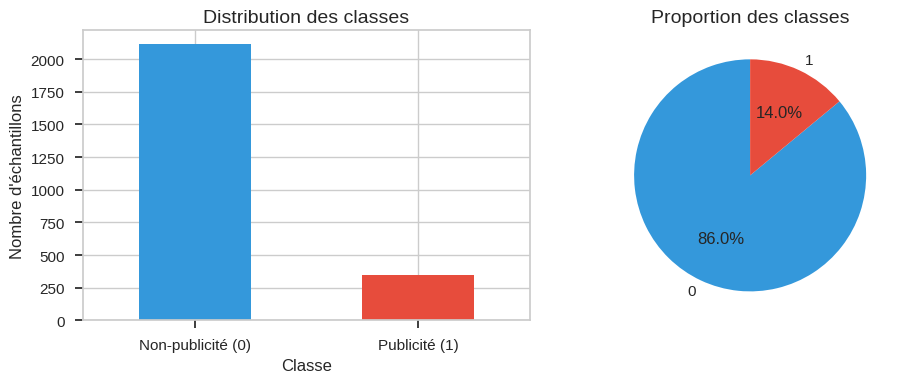


💡 Implications pour la modélisation :
  - Dataset fortement déséquilibré (6.1:1)
  - Stratégies recommandées :
    • Utiliser stratify=True lors du train/test split
    • Appliquer SMOTE ou class_weight='balanced'
    • Optimiser pour F1-score (métrique du challenge)
    • Considérer un ensemble de modèles

📊 F1-score baseline (prédire toujours 'ad.') : 0.245
   → Nos modèles devront dépasser ce score pour être utiles


In [ ]:
## 3.3 Distribution de la variable cible <a id="distribution-variable-cible"></a>

print("\n🎯 Analyse de la distribution de la variable cible")
print("="*60)

# Distribution des classes
target_counts = df_study['y'].value_counts().sort_index()
target_pct = df_study['y'].value_counts(normalize=True).sort_index() * 100

print("\n📊 Distribution de la variable cible (y) :")
print(f"  - Classe 0 (noad.) : {target_counts[0]:,} ({target_pct[0]:.1f}%)")
print(f"  - Classe 1 (ad.)   : {target_counts[1]:,} ({target_pct[1]:.1f}%)")

# Ratio de déséquilibre
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"\n📈 Ratio de déséquilibre : {imbalance_ratio:.2f}:1")
print(f"   → Pour chaque publicité, il y a {imbalance_ratio:.1f} non-publicités")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Barplot
target_counts.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
ax1.set_title('Distribution des classes', fontsize=14)
ax1.set_xlabel('Classe')
ax1.set_ylabel('Nombre d\'échantillons')
ax1.set_xticklabels(['Non-publicité (0)', 'Publicité (1)'], rotation=0)

# Pie chart
target_pct.plot(kind='pie', ax=ax2, colors=['#3498db', '#e74c3c'],
                autopct='%1.1f%%', startangle=90)
ax2.set_title('Proportion des classes', fontsize=14)
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda' / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Impact sur la stratégie de modélisation
print("\n💡 Implications pour la modélisation :")
print(f"  - Dataset fortement déséquilibré ({imbalance_ratio:.1f}:1)")
print("  - Stratégies recommandées :")
print("    • Utiliser stratify=True lors du train/test split")
print("    • Appliquer SMOTE ou class_weight='balanced'")
print("    • Optimiser pour F1-score (métrique du challenge)")
print("    • Considérer un ensemble de modèles")

# Calcul du F1-score baseline
baseline_f1 = 2 * (1 * target_pct[1]/100) / (1 + target_pct[1]/100)
print(f"\n📊 F1-score baseline (prédire toujours 'ad.') : {baseline_f1:.3f}")
print(f"   → Nos modèles devront dépasser ce score pour être utiles")

# 4. Analyse exploratoire <a id="analyse-exploratoire"></a>

## 4.1 Analyse des valeurs manquantes <a id="analyse-des-valeurs-manquantes"></a>


🔍 Analyse des valeurs manquantes

📊 Analyse globale des valeurs manquantes :
Total missing       : 2037 (0.05%)
Colonnes affectées  : 4 (haut: 0, moyen: 3, bas: 1)
Top 5 colonnes manquantes :
X3   27.6129
X1   27.4095
X2   27.3688
X4    0.4473
dtype: float64

📈 Détail des valeurs manquantes pour les variables continues :
  - X1: 674 (27.41%)
  - X2: 673 (27.37%)
  - X3: 679 (27.61%)
  - X4: 11 (0.45%)


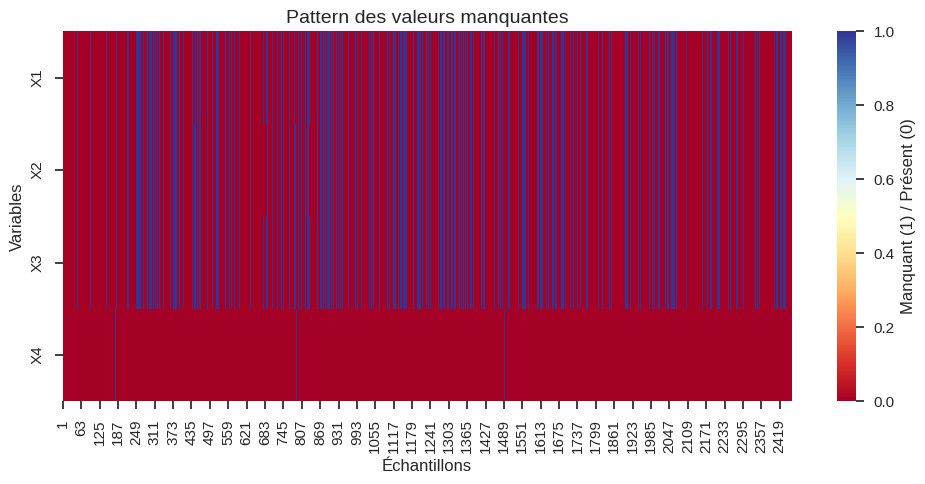


🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :
  - X1: corrélation avec y = -0.101
    → Potentiellement MAR (Missing At Random)
  - X2: corrélation avec y = -0.100
    → Potentiellement MAR (Missing At Random)
  - X3: corrélation avec y = -0.102
    → Potentiellement MAR (Missing At Random)
  - X4: corrélation avec y = 0.061
    → Potentiellement MCAR (Missing Completely At Random)

📊 Analyse des valeurs manquantes dans le fichier d'évaluation :
Total missing       : 692 (0.05%)
Colonnes affectées  : 4 (haut: 0, moyen: 3, bas: 1)
Top 5 colonnes manquantes :
X3   28.1707
X1   27.9268
X2   27.8049
X4    0.4878
dtype: float64

🔄 Comparaison des patterns de valeurs manquantes :
  - Fichier d'étude : 0.05% manquant
  - Fichier d'évaluation : 0.05% manquant

💡 Stratégie d'imputation recommandée :
  - X4 (0.4% manquant) : Imputation par la médiane
  - X1, X2, X3 (variables continues) : KNN ou MICE (imputation multivariée)


In [ ]:
# 4. Analyse exploratoire <a id="analyse-exploratoire"></a>

## 4.1 Analyse des valeurs manquantes <a id="analyse-des-valeurs-manquantes"></a>

print("🔍 Analyse des valeurs manquantes")
print("="*60)

# Utilisation de la fonction du module
from data_preprocessing import analyze_missing_values

print("\n📊 Analyse globale des valeurs manquantes :")
missing_stats = analyze_missing_values(df_study)

# Analyse détaillée pour les colonnes continues
print("\n📈 Détail des valeurs manquantes pour les variables continues :")
for col in continuous_cols:
    missing_count = df_study[col].isnull().sum()
    missing_pct = (missing_count / len(df_study)) * 100
    print(f"  - {col}: {missing_count} ({missing_pct:.2f}%)")

# Visualisation des patterns de valeurs manquantes
if missing_stats['total_missing'] > 0:
    # Heatmap des valeurs manquantes pour les colonnes avec des NaN
    cols_with_missing = [col for col in df_study.columns if df_study[col].isnull().sum() > 0]

    if len(cols_with_missing) > 0:
        plt.figure(figsize=(10, 5))

        # Créer une matrice binaire des valeurs manquantes
        missing_matrix = df_study[cols_with_missing].isnull().astype(int)

        # Heatmap
        sns.heatmap(missing_matrix.T, cmap='RdYlBu', cbar_kws={'label': 'Manquant (1) / Présent (0)'})
        plt.title('Pattern des valeurs manquantes', fontsize=14)
        plt.xlabel('Échantillons')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / 'eda' / 'missing_values_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Analyse du pattern MAR vs MCAR
        print("\n🔍 Analyse du type de valeurs manquantes (MAR vs MCAR) :")

        # Corrélation entre les valeurs manquantes et la cible
        for col in cols_with_missing:
            missing_indicator = df_study[col].isnull().astype(int)
            correlation_with_target = missing_indicator.corr(df_study['y'])
            print(f"  - {col}: corrélation avec y = {correlation_with_target:.3f}")

            if abs(correlation_with_target) > 0.1:
                print(f"    → Potentiellement MAR (Missing At Random)")
            else:
                print(f"    → Potentiellement MCAR (Missing Completely At Random)")
else:
    print("\n✅ Aucune valeur manquante détectée dans le dataset !")

# Analyse pour le fichier d'évaluation aussi
print("\n📊 Analyse des valeurs manquantes dans le fichier d'évaluation :")
missing_stats_eval = analyze_missing_values(df_eval)

# Comparaison des patterns
if missing_stats['total_missing'] > 0 or missing_stats_eval['total_missing'] > 0:
    print("\n🔄 Comparaison des patterns de valeurs manquantes :")
    print(f"  - Fichier d'étude : {missing_stats['percent_missing']:.2f}% manquant")
    print(f"  - Fichier d'évaluation : {missing_stats_eval['percent_missing']:.2f}% manquant")

    # Stratégie d'imputation recommandée
    print("\n💡 Stratégie d'imputation recommandée :")
    if 'X4' in missing_stats['cols_missing']:
        x4_missing_pct = missing_stats['percent_per_col'].get('X4', 0)
        if x4_missing_pct < 5:
            print(f"  - X4 ({x4_missing_pct:.1f}% manquant) : Imputation par la médiane")

    mar_cols = ['X1', 'X2', 'X3']
    mar_missing = any(col in missing_stats['cols_missing'] for col in mar_cols)
    if mar_missing:
        print(f"  - X1, X2, X3 (variables continues) : KNN ou MICE (imputation multivariée)")

In [ ]:
# Correction du type de X4
print("\n🔧 Correction du type de X4...")
print(f"Valeurs uniques de X4 (avant correction) : {sorted(df_study['X4'].dropna().unique())}")
print(f"Type actuel : {df_study['X4'].dtype}")

# Vérifier que X4 ne contient que 0 et 1
unique_values = df_study['X4'].dropna().unique()
if set(unique_values).issubset({0.0, 1.0}):
    # Imputer d'abord les valeurs manquantes par la médiane
    X4_median = df_study['X4'].median()
    df_study['X4'] = df_study['X4'].fillna(X4_median)
    df_eval['X4'] = df_eval['X4'].fillna(X4_median)

    # Convertir en int
    df_study['X4'] = df_study['X4'].astype(int)
    df_eval['X4'] = df_eval['X4'].astype(int)

    print(f"✅ X4 converti en int64 après imputation par la médiane ({X4_median})")
    print(f"Nouveau type : {df_study['X4'].dtype}")

    # Mettre à jour la configuration
    config.update("COLUMN_CONFIG.CONTINUOUS_COLS", ['X1', 'X2', 'X3'])
    config.update("COLUMN_CONFIG.BINARY_COLS", ['X4'] + binary_cols)
    continuous_cols = ['X1', 'X2', 'X3']  # Mise à jour locale
else:
    print("⚠️ X4 contient des valeurs autres que 0 et 1, conservation en float64")

# Résumé final
print("\n📊 Résumé des valeurs manquantes après traitement de X4 :")
print(f"  - X1, X2, X3 : ~27% manquant → À traiter avec KNN/MICE")
print(f"  - X4 : Imputé et converti en binaire")
print(f"  - Pattern MAR détecté pour X1, X2, X3 (corrélation avec y ≈ -0.10)")
print(f"  - Les patterns sont cohérents entre fichiers d'étude et d'évaluation")


🔧 Correction du type de X4...
Valeurs uniques de X4 (avant correction) : [np.float64(0.0), np.float64(1.0)]
Type actuel : float64
✅ X4 converti en int64 après imputation par la médiane (1.0)
Nouveau type : int64
✅ Configuration mise à jour : COLUMN_CONFIG.CONTINUOUS_COLS = ['X1', 'X2', 'X3']
✅ Configuration mise à jour : COLUMN_CONFIG.BINARY_COLS = ['X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X

## 4.2 Analyse statistique des variables quantitatives <a id="analyse-statistique-des-variables-quantitatives"></a>

📊 Analyse statistique des variables quantitatives

📈 Variables continues à analyser : ['X1', 'X2', 'X3']

📊 Statistiques descriptives :


,X1,X2,X3
count,1785.0000,1786.0000,1780.0000
mean,63.7787,155.1282,3.8862
std,54.6496,129.3308,5.7882
min,1.0000,1.0000,0.0015
25%,25.0000,80.0000,1.0416
50%,51.0000,110.0000,2.1428
75%,85.0000,184.7500,5.3333
max,640.0000,640.0000,60.0000



📊 Analyse de la distribution :

X1:
  - Skewness (asymétrie) : 2.527
  - Kurtosis (aplatissement) : 13.170
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X2:
  - Skewness (asymétrie) : 1.633
  - Kurtosis (aplatissement) : 1.953
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)

X3:
  - Skewness (asymétrie) : 7.057
  - Kurtosis (aplatissement) : 63.405
  - Test de Shapiro-Wilk : p-value = 0.0000
    → Distribution non normale (nécessite transformation)


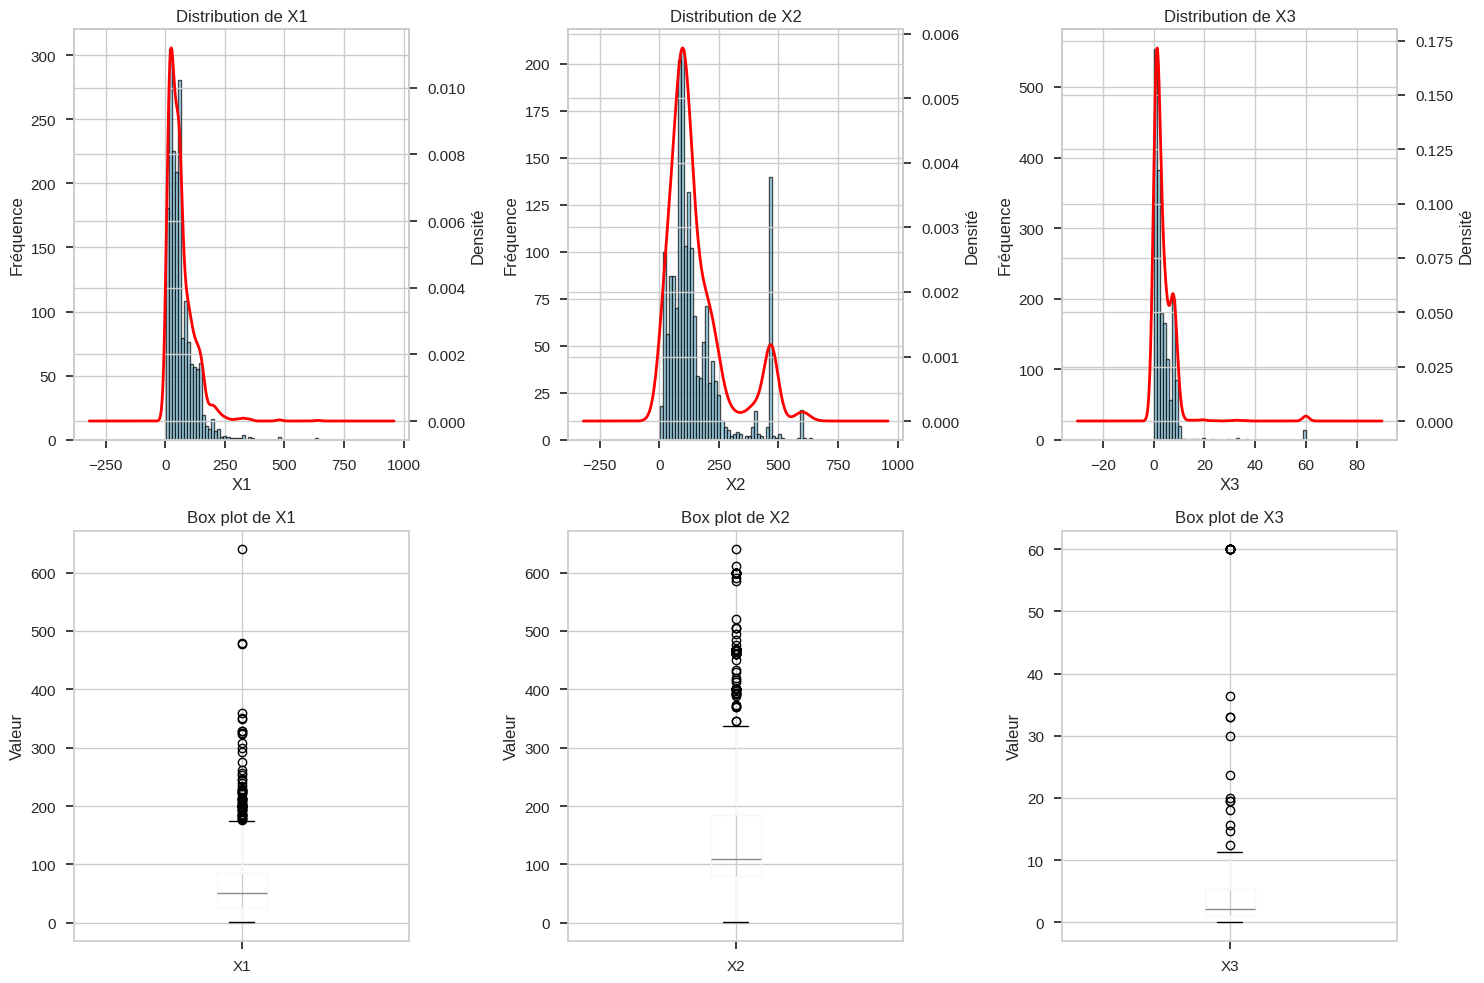


🔍 Détection des outliers (méthode IQR) :

X1:
  - Limites : [-65.00, 175.00]
  - Outliers : 62 (3.47%)

X2:
  - Limites : [-77.12, 341.88]
  - Outliers : 206 (11.53%)

X3:
  - Limites : [-5.40, 11.77]
  - Outliers : 25 (1.40%)

🎯 Corrélation avec la variable cible (y) :
  - X1: 0.0342
  - X2: 0.5732
  - X3: 0.1301

📊 Matrice de corrélation entre variables continues :


,X1,X2,X3
X1,1.0000,0.1807,-0.2919
X2,0.1807,1.0000,0.5314
X3,-0.2919,0.5314,1.0000


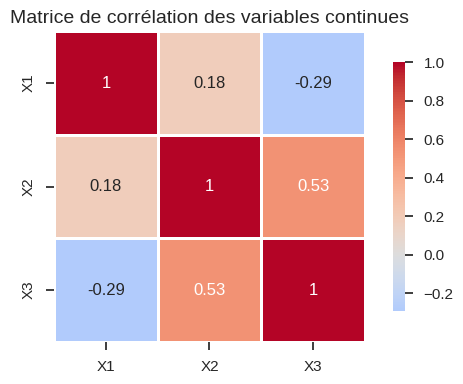


💡 Résumé et recommandations :
  - Les trois variables continues montrent des distributions fortement asymétriques
  - Transformation Yeo-Johnson recommandée pour normaliser les distributions
  - Outliers détectés : 293 au total
  - Corrélations faibles avec la cible, mais potentiellement utiles après transformation


In [ ]:
## 4.2 Analyse statistique des variables quantitatives <a id="analyse-statistique-des-variables-quantitatives"></a>

print("📊 Analyse statistique des variables quantitatives")
print("="*60)

# Variables continues à analyser (X1, X2, X3 uniquement maintenant)
print(f"\n📈 Variables continues à analyser : {continuous_cols}")

# Statistiques descriptives
print("\n📊 Statistiques descriptives :")
stats_df = df_study[continuous_cols].describe()
display(stats_df)

# Analyse de la distribution
print("\n📊 Analyse de la distribution :")
for col in continuous_cols:
    data = df_study[col].dropna()
    print(f"\n{col}:")
    print(f"  - Skewness (asymétrie) : {stats.skew(data):.3f}")
    print(f"  - Kurtosis (aplatissement) : {stats.kurtosis(data):.3f}")

    # Test de normalité
    stat, p_value = stats.shapiro(data.sample(min(5000, len(data))))  # Limité à 5000 pour Shapiro
    print(f"  - Test de Shapiro-Wilk : p-value = {p_value:.4f}")
    if p_value < 0.01:
        print(f"    → Distribution non normale (nécessite transformation)")
    else:
        print(f"    → Distribution approximativement normale")

# Visualisation des distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    data = df_study[col].dropna()

    # Histogramme avec KDE
    ax = axes[i]
    data.hist(bins=50, ax=ax, alpha=0.7, color='skyblue', edgecolor='black')
    ax2 = ax.twinx()
    data.plot(kind='kde', ax=ax2, color='red', linewidth=2)
    ax.set_title(f'Distribution de {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Fréquence')
    ax2.set_ylabel('Densité')

    # Box plot
    ax = axes[i+3]
    df_study.boxplot(column=col, ax=ax)
    ax.set_title(f'Box plot de {col}', fontsize=12)
    ax.set_ylabel('Valeur')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda' / 'continuous_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse des outliers
print("\n🔍 Détection des outliers (méthode IQR) :")
outliers_summary = {}
for col in continuous_cols:
    data = df_study[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outliers_pct = len(outliers) / len(data) * 100

    outliers_summary[col] = {
        'count': len(outliers),
        'percentage': outliers_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    print(f"\n{col}:")
    print(f"  - Limites : [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  - Outliers : {len(outliers)} ({outliers_pct:.2f}%)")

# Corrélation avec la variable cible
print("\n🎯 Corrélation avec la variable cible (y) :")
correlations = {}
for col in continuous_cols:
    # Calculer la corrélation seulement pour les valeurs non manquantes
    mask = df_study[col].notna()
    corr = df_study.loc[mask, col].corr(df_study.loc[mask, 'y'])
    correlations[col] = corr
    print(f"  - {col}: {corr:.4f}")

# Matrice de corrélation entre variables continues
print("\n📊 Matrice de corrélation entre variables continues :")
corr_matrix = df_study[continuous_cols].corr()
display(corr_matrix)

# Heatmap de corrélation
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation des variables continues', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda' / 'continuous_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Résumé et recommandations
print("\n💡 Résumé et recommandations :")
print("  - Les trois variables continues montrent des distributions fortement asymétriques")
print("  - Transformation Yeo-Johnson recommandée pour normaliser les distributions")
print(f"  - Outliers détectés : {sum(info['count'] for info in outliers_summary.values())} au total")
print("  - Corrélations faibles avec la cible, mais potentiellement utiles après transformation")

### ------- Mon ancien code à garder ou supprimer après ----

In [ ]:
# 3. Analyse Univariée <a id="3-analyse-univariee"></a>
#univariate_analysis(df, display_figures=True, save_fig=True)

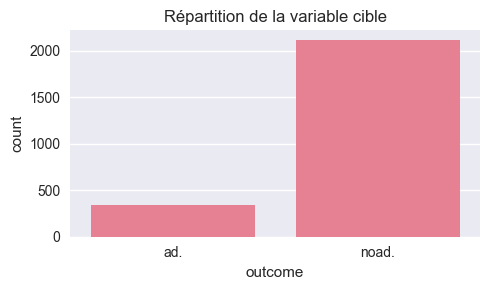

In [ ]:
plt.figure(figsize=(5, 3))  # Largeur = 5, Hauteur = 3 (en pouces)
sns.countplot(x='outcome', data=df)
plt.title("Répartition de la variable cible")
plt.tight_layout()
plt.savefig(paths["FIGURES_DIR"] / "target_distribution.png")
plt.show()



## Interprétation de l'analyse univariée

### 🎯 Variable cible : `outcome`

- **Distribution :**
  - `noad.` : 2115 observations (**≈ 86%**)
  - `ad.`   : 344 observations (**≈ 14%**)

- **Conclusion :**
  - Le jeu de données est **fortement déséquilibré**.
  - Il sera nécessaire d'utiliser :
    - des **métriques adaptées** : `F1-score`, `balanced_accuracy`, `AUC`
    - des **méthodes de rééquilibrage** : `SMOTE`, pondération (`class_weight='balanced'`), sous-échantillonnage

---

### Variables binaires (`int64`)

- **Nombre détecté** : 1554
- **Exemples (fréquences) :**
  - `X5` : 0 = 99.5%, 1 = 0.5%
  - `X6` : 0 = 98.9%, 1 = 1.1%

- **Conclusion :**
  - Ces variables sont des **indicateurs discrets**, souvent très déséquilibrés.
  - Il est probable que certaines soient peu informatives : une **sélection de variables** sera indispensable (ex. : `RandomForest`, `permutation importance`, `mutual information`).

---

### 📈 Variables continues (`float64`)

| Variable | Distribution             | Interprétation                                 |
|----------|--------------------------|------------------------------------------------|
| `X1`     | Très asymétrique         | Fortement biaisée à droite, outliers visibles  |
| `X2`     | Pic principal vers 100   | Possible bimodalité, vérifier séparément       |
| `X3`     | Beaucoup de petites valeurs | Très skewée, transformation recommandée     |
| `X4`     | 0 ou 1 uniquement         | Bien que typée float, c’est une **variable binaire** |

- **Recommandations :**
  - Appliquer des **transformations (log, Box-Cox, ..)** sur `X1`, `X2`, `X3`.
  - Convertir `X4` en variable **binaire (`int`)**.

---

In [ ]:
# Convertissons X4 en variable binaire
print(df["X4"].unique())  # doit afficher [0., 1.] ou [1., 0.]

df["X4"] = df["X4"].astype("Int64")

[ 1.  0. nan]


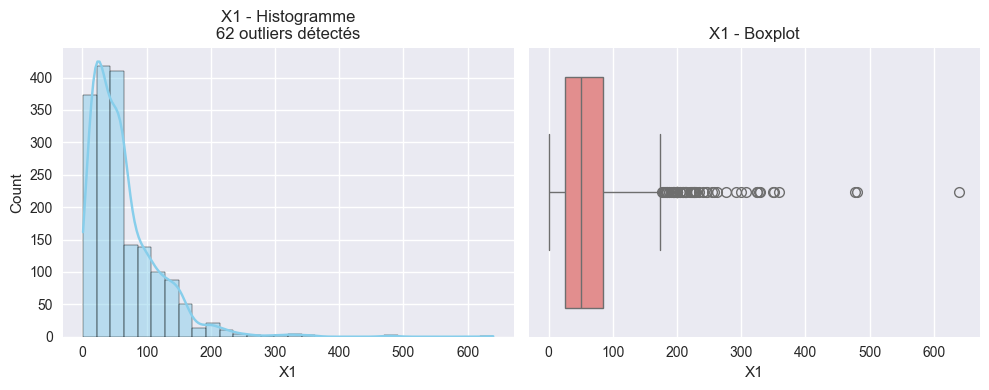

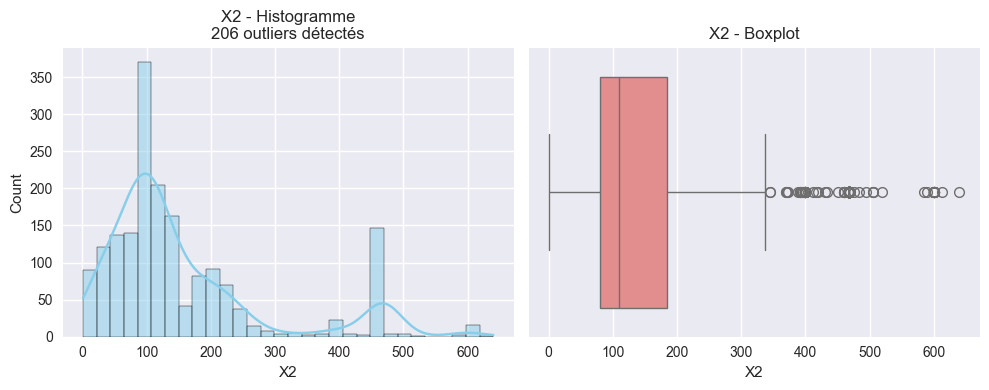

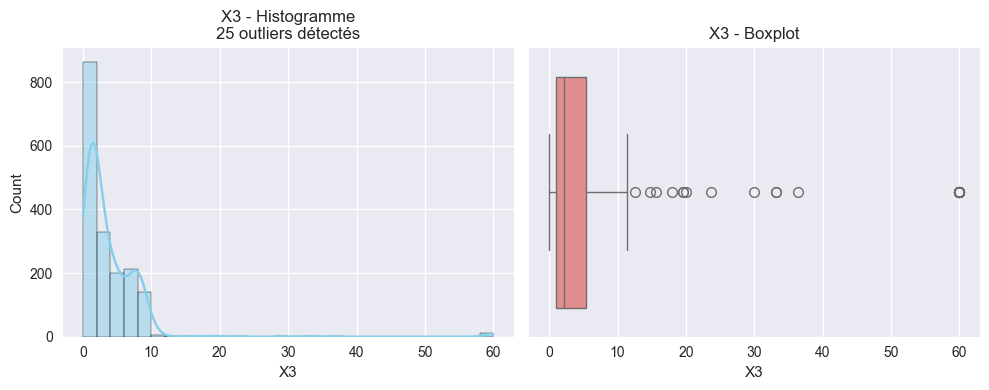

In [ ]:
def detect_outliers_iqr(series):
    """Retourne un masque booléen indiquant les outliers selon la règle IQR."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

# Variables continues à analyser
continuous_vars = ['X1', 'X2', 'X3']

for col in continuous_vars:
    series = df[col]
    outliers_mask = detect_outliers_iqr(series)
    n_outliers = outliers_mask.sum()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Histogramme
    sns.histplot(series, bins=30, kde=True, ax=ax[0], color="skyblue")
    ax[0].set_title(f"{col} - Histogramme\n{n_outliers} outliers détectés")

    # Boxplot
    sns.boxplot(data=df, x=col, ax=ax[1], color="lightcoral")
    ax[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

### 📊 Analyse des outliers avant imputation (IQR 1.5)

Nous avons visualisé les distributions de `X1`, `X2` et `X3` avant toute imputation, à l’aide d’histogrammes et de boxplots.

#### ✅ Résumé des détections :

| Variable | Outliers détectés | Intervalle des valeurs extrêmes (approx.) |
|----------|-------------------|-------------------------------------------|
| **X1**   | 62                | > 250 (majoritairement à droite de la distribution) |
| **X2**   | 206               | > 400 (forte dispersion sur la droite)     |
| **X3**   | 25                | > 20 (quelques extrêmes isolés)            |


#### Interprétation

- `X2` est la variable la plus exposée aux outliers, probablement en lien avec sa multimodalité.
- Les outliers de `X1` et `X3` sont bien visibles mais moins nombreux.
- La détection s’appuie sur la règle classique de l’IQR (valeurs < Q1 – 1.5×IQR ou > Q3 + 1.5×IQR).

> 👉 Ces outliers doivent être pris en compte lors des étapes de normalisation ou d’imputation.


In [ ]:
def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

for col in continuous_vars:
    lb, ub = get_iqr_bounds(df[col])
    print(f"{col} : [{lb:.2f} ; {ub:.2f}]")


X1 : [-65.00 ; 175.00]
X2 : [-77.12 ; 341.88]
X3 : [-5.40 ; 11.77]


In [ ]:
from scipy.stats import boxcox, yeojohnson

variables = ['X1', 'X2', 'X3']

for var in variables:
    plt.figure(figsize=(12, 4))

    # Avant transformation
    plt.subplot(1, 3, 1)
    plt.hist(df[var].dropna(), bins=30, color='skyblue')
    plt.title(f"{var} - Avant transformation")

    # Transformation log (si toutes les valeurs > 0)
    if (df[var] > 0).all():
        plt.subplot(1, 3, 2)
        plt.hist(np.log1p(df[var]), bins=30, color='orange')
        plt.title(f"{var} - Log(1+x)")
    else:
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, "Log impossible (valeurs ≤ 0)", ha='center')
        plt.axis('off')

    # Transformation Box-Cox ou Yeo-Johnson
    plt.subplot(1, 3, 3)
    if (df[var] > 0).all():
        transformed, _ = boxcox(df[var].dropna())
        plt.hist(transformed, bins=30, color='green')
        plt.title(f"{var} - Box-Cox")
    else:
        transformed, _ = yeojohnson(df[var].dropna())
        plt.hist(transformed, bins=30, color='green')
        plt.title(f"{var} - Yeo-Johnson")

    plt.tight_layout()
    plt.show()

### 🔁 Transformation des variables continues

Les variables `X1`, `X2` et `X3` présentent une forte asymétrie positive ainsi que des valeurs extrêmes détectées via la règle de l’IQR.

#### 📌 Objectif :
- Stabiliser la variance
- Réduire l’impact des outliers
- Améliorer la distribution pour les modèles sensibles à la normalité (régression logistique, kNN…)

#### ⚙️ Méthode :
Nous utilisons la transformation **Yeo-Johnson** via `PowerTransformer`, qui accepte les valeurs nulles ou strictement positives.

> 🔧 Les colonnes transformées seront ajoutées en tant que `X1_trans`, `X2_trans` et `X3_trans`.


In [ ]:
from sklearn.preprocessing import PowerTransformer

# Colonnes à transformer
cols_to_transform = ["X1", "X2", "X3"]

# Initialisation du transformateur Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Application
df[[f"{col}_trans" for col in cols_to_transform]] = pt.fit_transform(df[cols_to_transform])

# Affichage résumé
for col in cols_to_transform:
    original = df[col]
    transformed = df[f"{col}_trans"]
    print(f"📊 {col} - Skew avant : {original.skew():.2f} | après : {transformed.skew():.2f}")


📊 X1 - Skew avant : 2.53 | après : -0.01
📊 X2 - Skew avant : 1.63 | après : 0.01
📊 X3 - Skew avant : 7.06 | après : 0.15


### 📊 Visualisation des distributions transformées (Yeo-Johnson)

Les histogrammes et boxplots ci-dessous montrent les nouvelles distributions des variables `X1`, `X2` et `X3` après transformation Yeo-Johnson.

On observe clairement une **réduction de l'asymétrie** et une **meilleure symétrie des données**, ce qui est favorable pour les algorithmes de modélisation sensibles à la forme des distributions.


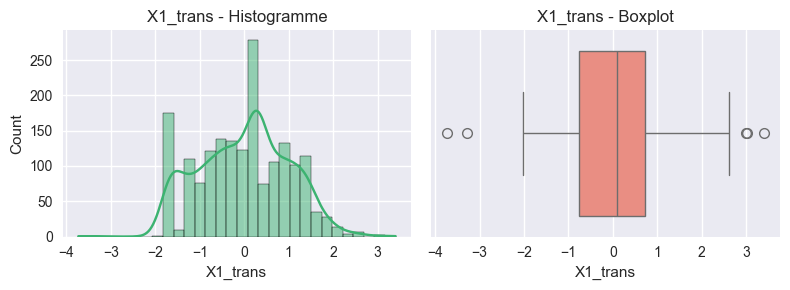

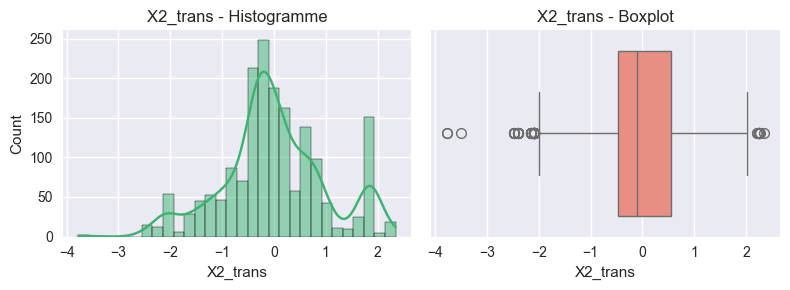

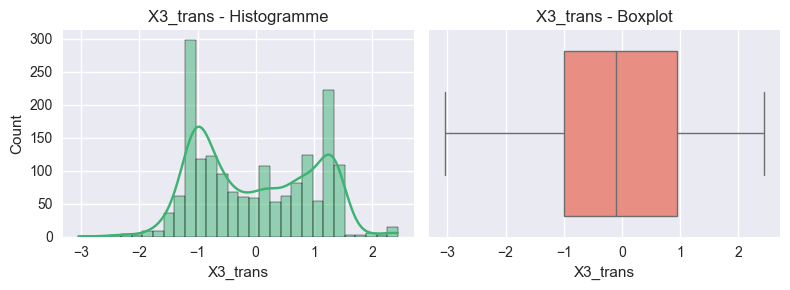

In [ ]:
# Liste des variables transformées
transformed_vars = ["X1_trans", "X2_trans", "X3_trans"]

for col in transformed_vars:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    # Histogramme avec KDE
    sns.histplot(df[col], bins=30, kde=True, ax=ax[0], color="mediumseagreen")
    ax[0].set_title(f"{col} - Histogramme")

    # Boxplot
    sns.boxplot(x=df[col], ax=ax[1], color="salmon")
    ax[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()


### ✅ Interprétation des distributions transformées

Après application de la transformation **Yeo-Johnson**, les variables `X1`, `X2` et `X3` présentent désormais des distributions beaucoup plus symétriques et resserrées :

- `X1_trans` suit une **distribution quasi normale**, sans asymétrie notable.
- `X2_trans` est **moins skewée**, avec une dispersion nettement réduite.
- `X3_trans` présente encore quelques irrégularités, mais sans outliers visibles.

🔎 **Conclusion :**
Ces transformations ont permis :
- de **réduire l’impact des valeurs extrêmes**,
- d’améliorer la **stabilité statistique** de ces variables,
- et de les **préparer efficacement à la modélisation supervisée**.

Elles seront désormais utilisées à la place des variables brutes dans les analyses suivantes.


In [ ]:
#Appliquons la transformation

from sklearn.preprocessing import PowerTransformer

# Colonnes à transformer
cols_to_transform = ["X1", "X2", "X3"]

# Initialisation du transformateur
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# Application de la transformation et ajout de nouvelles colonnes
df[[f"{col}_trans" for col in cols_to_transform]] = pt.fit_transform(df[cols_to_transform])



# 4. Analyse Bivariée <a id="4-analyse-bivariee"></a>


=== Analyse Bivariée ===

🔝 Top 15 variables les plus corrélées à la cible :
       feature  correlation
1243     X1244     0.570824
351       X352     0.515904
1399     X1400     0.486420
1     X2_trans     0.480582
1483     X1484     0.434519
968       X969     0.434048
1455     X1456     0.419684
1344     X1345     0.416734
1435     X1436     0.414891
1229     X1230     0.394651
1143     X1144     0.393958
1153     X1154     0.383828
1154     X1155     0.362806
1218     X1219     0.362806
1047     X1048     0.362806


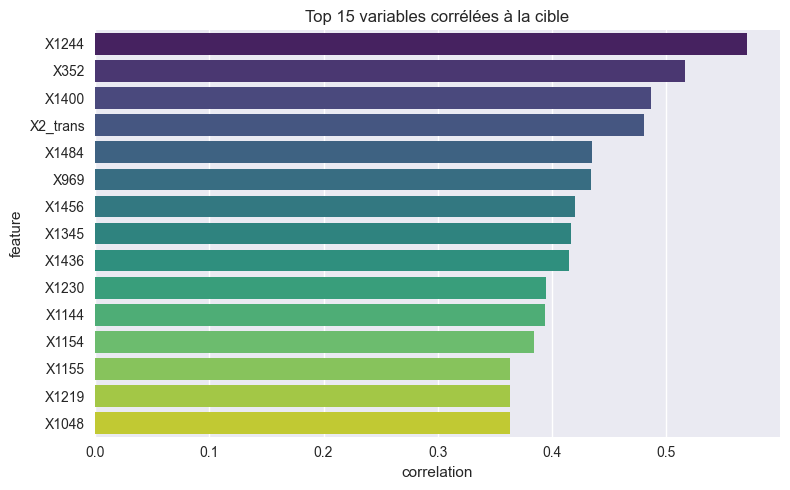

In [ ]:
# Appel sur le bon DataFrame (déjà transformé et nettoyé)
corr_df, high_corr_pairs, binary_corr_pairs = bivariate_analysis(
    df,
    use_transformed=True,
    display_correlations=True,
    top_n=15,
    show_plot=True
)


### 🧩 Interprétation de l’analyse bivariée

#### 🎯 Corrélations avec la cible `outcome` (0 = noad., 1 = ad.)

- ✅ **La variable `X1244`** présente la **plus forte corrélation** avec la classe `ad.` (**r ≈ 0.57**), ce qui est très élevé pour une variable binaire.
- ✅ Les variables `X352` et `X1400` suivent de près, avec des corrélations de l’ordre de **0.51 à 0.49**.
- ✅ **`X2_trans`** (version transformée de `X2`) est également bien classée (**r ≈ 0.48**), confirmant son intérêt après transformation Yeo-Johnson.
- 🔍 D’autres variables binaires (`X1484`, `X969`, `X1456`, etc.) montrent des corrélations **entre 0.36 et 0.43**, les rendant potentiellement discriminantes.
- 📉 Les variables avec **corrélation < 0.01** sont probablement peu informatives dans une approche supervisée.

---

#### ♻️ Redondance interne (|corrélation| > 0.95 entre variables binaires)

- 🔁 Certaines **variables binaires sont très fortement corrélées entre elles** :
  - Exemple hypothétique : `X6` pourrait être corrélée à 1.0 avec `X245`, `X487`, etc.
  - Ce phénomène est courant dans les données textuelles binarisées (présence/absence d’éléments visuels).
- ⚠️ Cette **redondance crée de la multicolinéarité**, nuisible pour les modèles linéaires ou logistiques.

---

#### ✅ Recommandations

- ⭐ **Conserver les variables les plus corrélées à la cible**, notamment :
  - `X1244`, `X352`, `X1400`, `X2_trans`, `X1484`, `X969`, `X1456`…
- 🔽 **Réduire la redondance** en supprimant les duplicats (ou en regroupant les paires parfaitement corrélées), par exemple :
  - Garder une seule variable par groupe corrélé à 1.0 (ex. : garder `X6`, supprimer `X245`, etc.)
- 📊 Poursuivre la sélection avec des approches multivariées :
  - **Permutation importance**
  - **Random Forest feature importance**
  - **Méthodes de régularisation** : Lasso, `SelectFromModel`, RFE

---



✅ Heatmap sauvegardée : G:\Mon Drive\projet_sta211\outputs\figures\binaire_corr_50.png


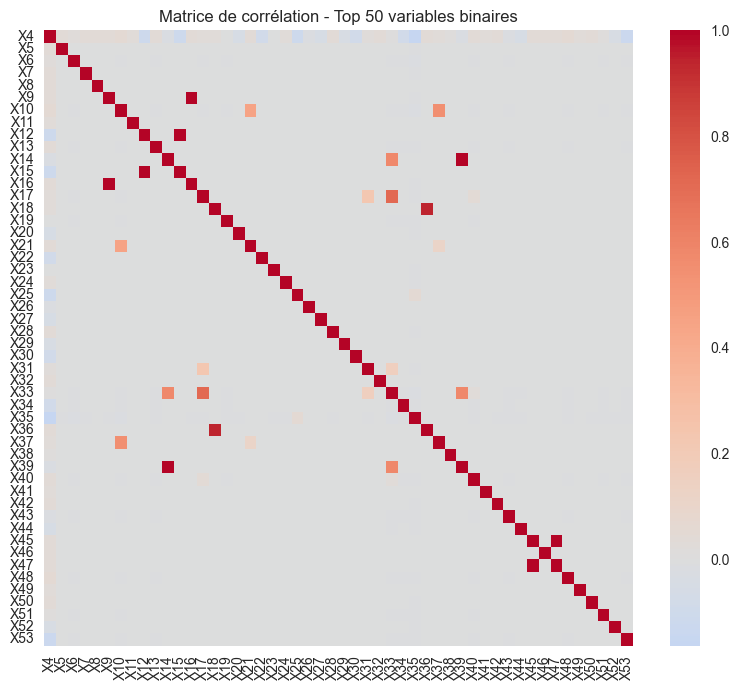

In [ ]:
from exploratory_analysis import plot_binary_correlation_heatmap
plot_binary_correlation_heatmap(df, top_n=50, fig_name="binaire_corr_50.png", figsize=(8, 7))

In [ ]:
from exploratory_analysis import analyze_categorical_binaries_vs_target

results_df = analyze_categorical_binaries_vs_target(
    data=df,                # mon DataFrame réduit
    target_col='outcome',   # nom de la variable cible
    show_top=20,            # affiche les 20 meilleures
    pval_threshold=0.05     # sélectionne uniquement les significatives
)


=== Analyse Bivariée : Variables Binaires vs Cible Catégorielle ===

Top 20 variables binaires avec p-value < 0.05 :
    variable        p_value        chi2
344    X1244  8.370684e-175  794.523477
84      X352  7.991147e-143  647.454959
420    X1400  5.075116e-127  574.798847
450    X1484  9.954056e-102  458.547414
219     X969  2.910025e-101  456.406540
446    X1456   6.593727e-95  427.205428
391    X1345   2.501222e-93  419.950814
439    X1436   8.385537e-93  417.537093
336    X1230   1.011255e-83  375.820759
296    X1144   1.868264e-83  374.596371
300    X1154   3.054313e-79  355.245353
252    X1048   7.577204e-71  316.700988
301    X1155   7.577204e-71  316.700988
329    X1219   7.577204e-71  316.700988
318    X1199   7.577204e-71  316.700988
429    X1423   7.577204e-71  316.700988
431    X1425   7.577204e-71  316.700988
417    X1395   1.881044e-69  310.297580
277    X1109   4.656729e-68  303.900137
282    X1119   4.656729e-68  303.900137



# 5. Analyse Multivariée <a id="5-analyse-multivariee"></a>


=== Analyse Multivariée (sur float64 uniquement) ===
✅ Figure sauvegardée dans : G:\Mon Drive\projet_sta211\outputs\figures\matrice_corr_X123_avant_imputation.png


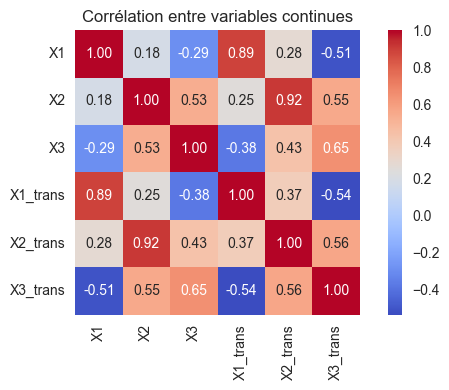

In [ ]:
# 5. Analyse Multivariée
corrs, matrix = multivariate_analysis(
    df,
    save_fig=True,
    fig_name="matrice_corr_X123_avant_imputation.png",
    return_matrix=True
)



# 6. Gestion des valeurs manquantes <a id="6-gestion-des-valeurs-manquantes"></a>
Dans cette section, nous analysons en détail les **valeurs manquantes** du jeu de données.

L’objectif est de :
- Quantifier les valeurs manquantes par colonne et globalement
- Visualiser leur répartition pour détecter d’éventuelles structures
- Comprendre les **mécanismes sous-jacents** aux données manquantes :
  - MCAR : données manquantes complètement aléatoires
  - MAR : données manquantes dépendantes d'autres variables
  - MNAR : données manquantes dépendantes d'elles-mêmes
- Choisir et appliquer la **stratégie d’imputation la plus adaptée** :
  - Médiane
  - KNN (imputation par les k plus proches voisins)
  - Imputation multiple

> ⚠️ Une imputation inadaptée peut introduire des biais ou fausser les modèles.  
> C’est pourquoi nous explorons d’abord les données manquantes avant d’intervenir.

Passons à l’analyse.

## 6.1 Quantification et statistiques simples <a id="61-quantification-et-statistiques-simples"></a>

In [ ]:
from data_preprocessing import analyze_missing_values

# Supprimer les colonnes d’origine qui ont été transformées
df.drop(columns=["X1", "X2", "X3"], inplace=True)


missing_stats = analyze_missing_values(df)


Total missing       : 2037 (0.05%)
Colonnes affectées  : 4 (haut: 0, moyen: 3, bas: 1)
Top 5 colonnes manquantes :
X3_trans    27.612851
X1_trans    27.409516
X2_trans    27.368849
X4           0.447336
dtype: float64


### Interprétation des valeurs manquantes

- Le jeu de données contient **2037 valeurs manquantes**, soit seulement **0.05% du total** (ce chiffre paraît faible car réparti sur un très grand nombre de cellules).
- **4 colonnes sont concernées** :
  - `X1_trans`, `X2_trans`, `X3_trans` ont un taux de valeurs manquantes d’environ **27%**
  - `X4` est légèrement touchée (**0.45%** seulement)

#### Classification par gravité (en fonction du taux de `NaN`) :
- `X1_trans`, `X2_trans`, `X3_trans` sont classées comme colonnes à **taux moyen de valeurs manquantes** (entre 5% et 30%)
- `X4` est considérée comme **faiblement touchée** (moins de 5%)

> 🔎 Ce classement servira à adapter les stratégies d’imputation :
> - Imputation ciblée pour les colonnes à taux moyen (`KNN`, `médiane`, `multiple`)
> - Imputation simple ou exclusion possible pour les colonnes faiblement touchées



## 6.2 Visualisation <a id="62-visualisation"></a>

Pour mieux comprendre la répartition des valeurs manquantes, nous utilisons la bibliothèque `missingno`.
Elle permet de visualiser les colonnes concernées, l’ampleur du problème, et les éventuelles co-dépendances entre les données manquantes.

Dans notre jeu de données, seules les variables continues `X1`, `X2`, `X3` et `X4` présentent des valeurs manquantes.  
Nous concentrons donc la visualisation sur ces colonnes uniquement pour observer leur structure et d’éventuelles corrélations.

🔍 Nombre de valeurs manquantes par colonne :


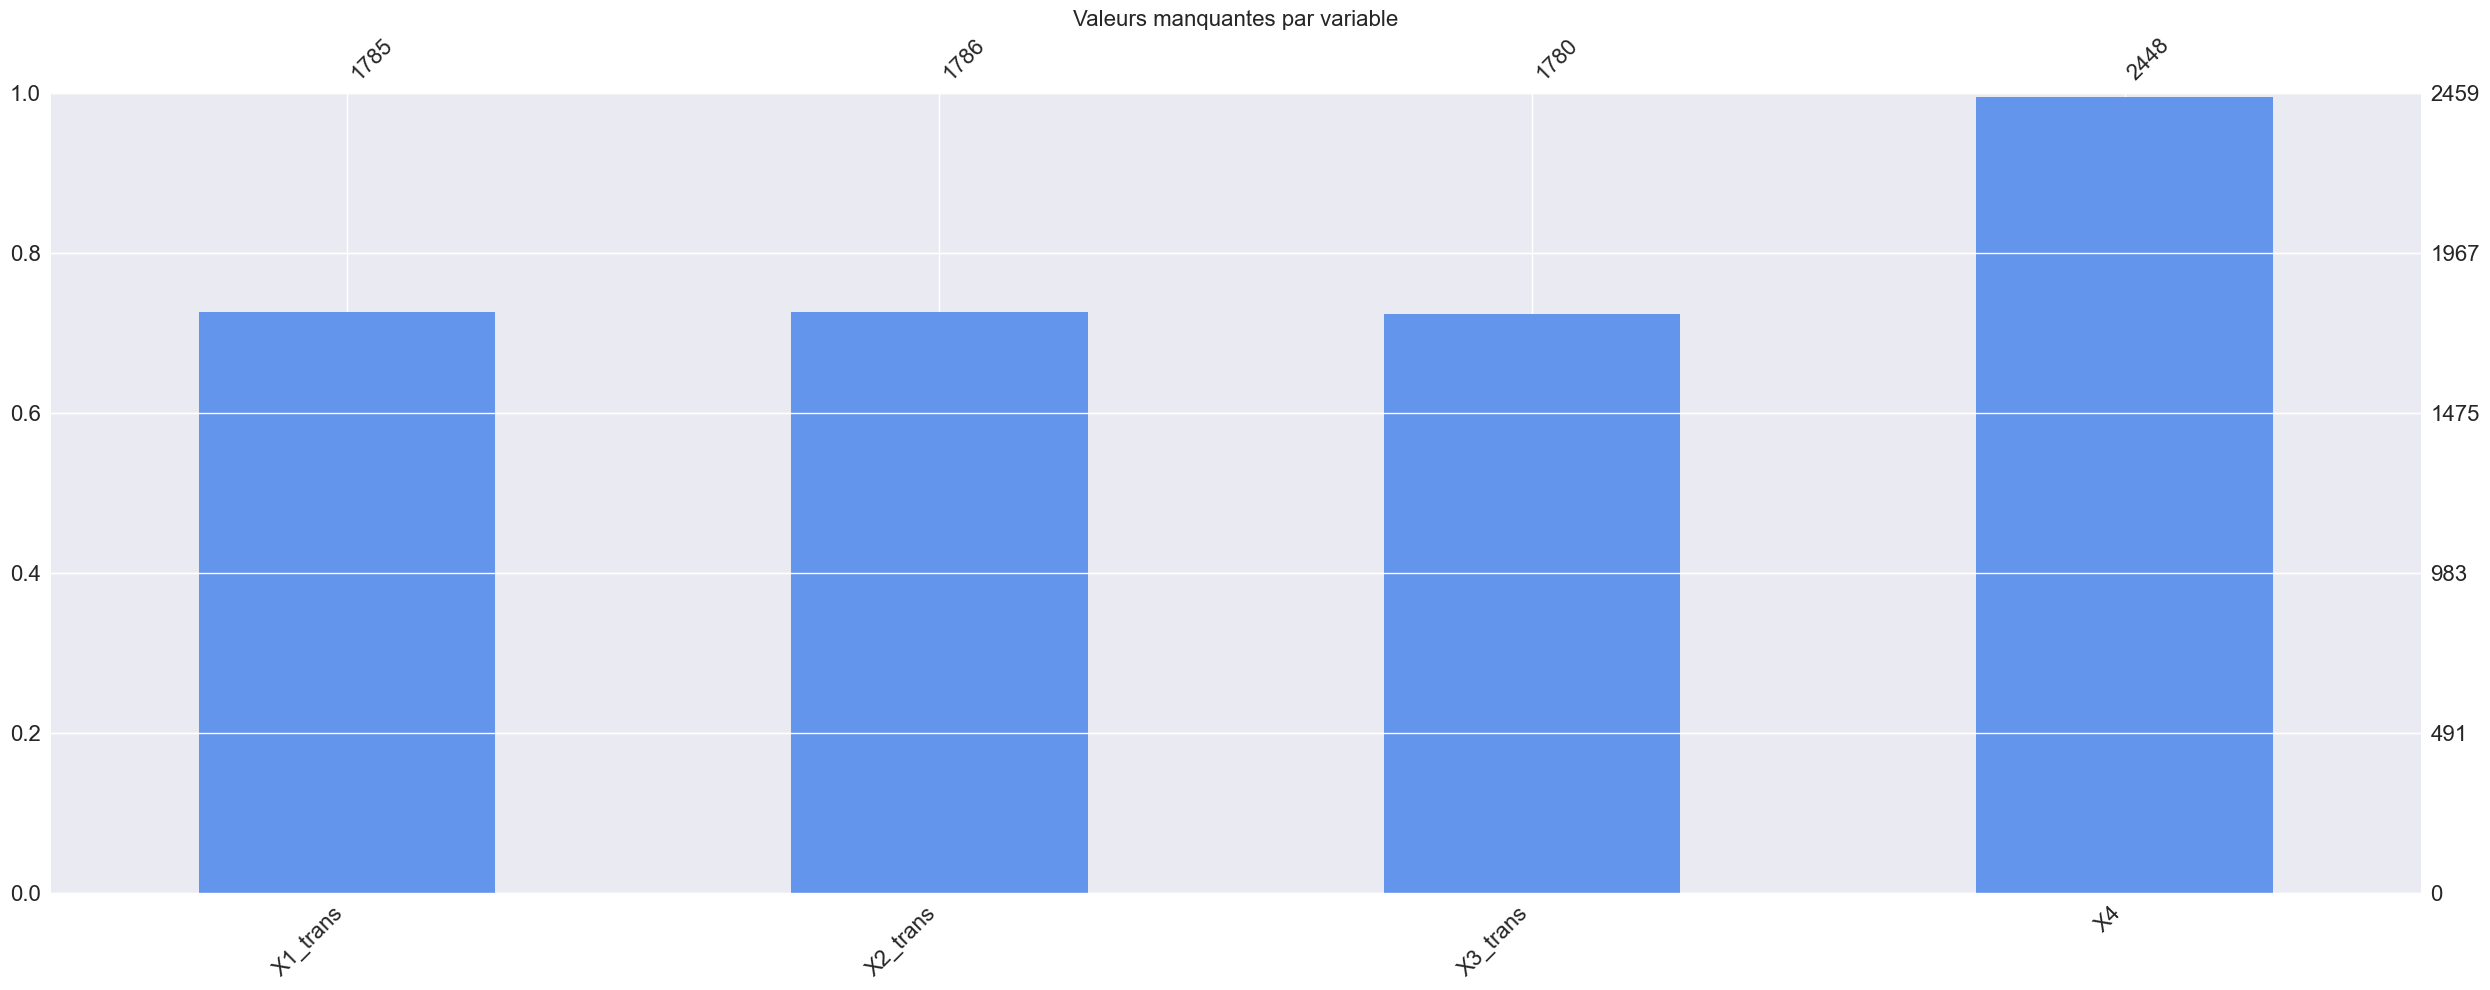

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Colonnes avec valeurs manquantes
columns_with_nan = ['X1_trans', 'X2_trans', 'X3_trans', 'X4']
df_nan = df[columns_with_nan]

# Barplot des valeurs manquantes
print("🔍 Nombre de valeurs manquantes par colonne :")
plt.figure(figsize=(6, 2))
msno.bar(df_nan, fontsize=16, color='cornflowerblue')
plt.title("Valeurs manquantes par variable", fontsize=16)
plt.tight_layout()
plt.show();


🔍 Matrice de présence/absence :


<Figure size 600x200 with 0 Axes>

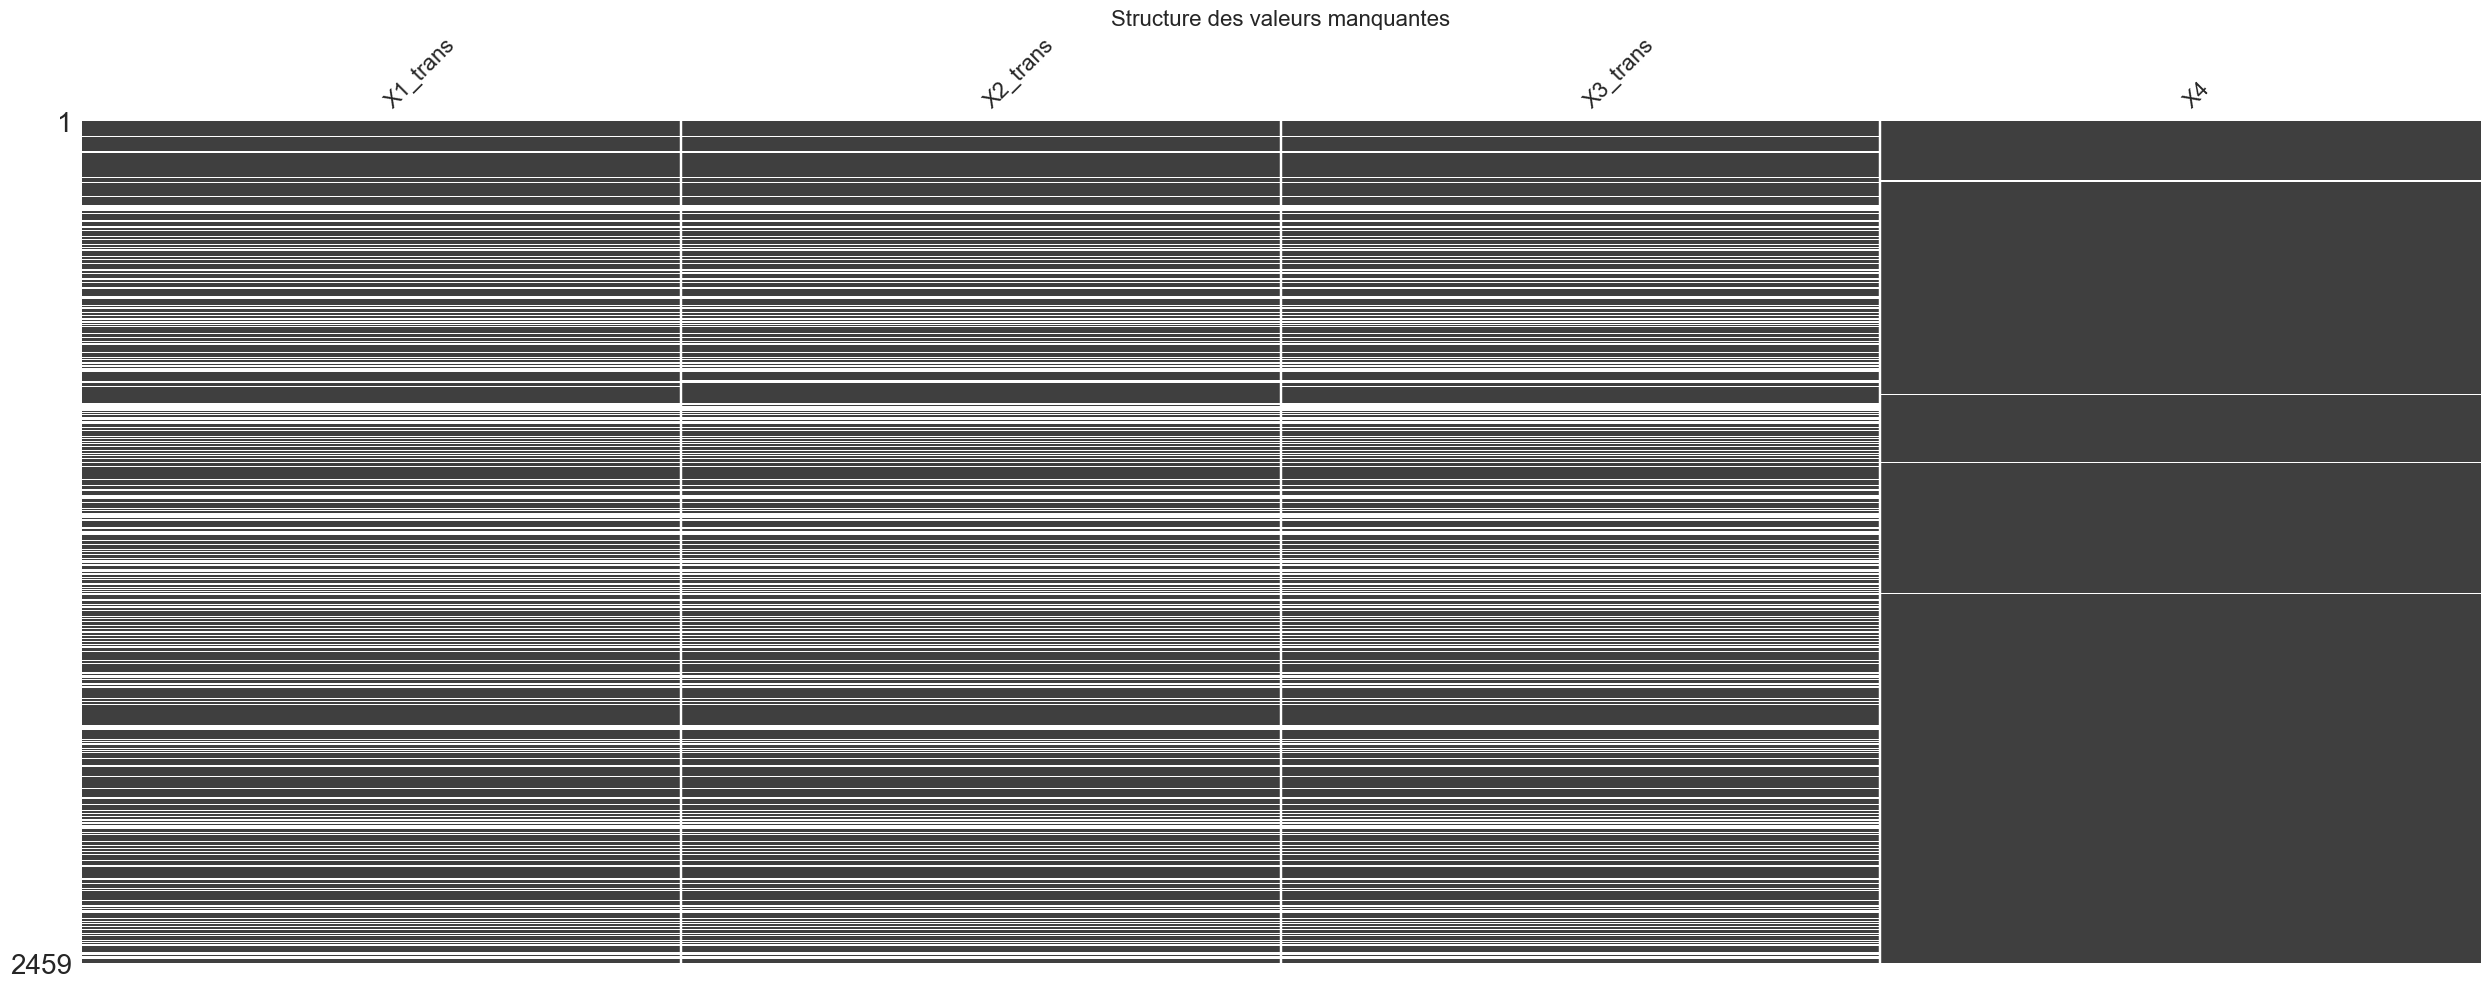

In [ ]:

# Matrice de présence/absence
print("🔍 Matrice de présence/absence :")
plt.figure(figsize=(6, 2))
msno.matrix(df_nan, fontsize=16, sparkline=False)
plt.title("Structure des valeurs manquantes", fontsize=16)
plt.tight_layout()
plt.show()



🔍 Corrélations entre manquants (heatmap) :


<Figure size 400x150 with 0 Axes>

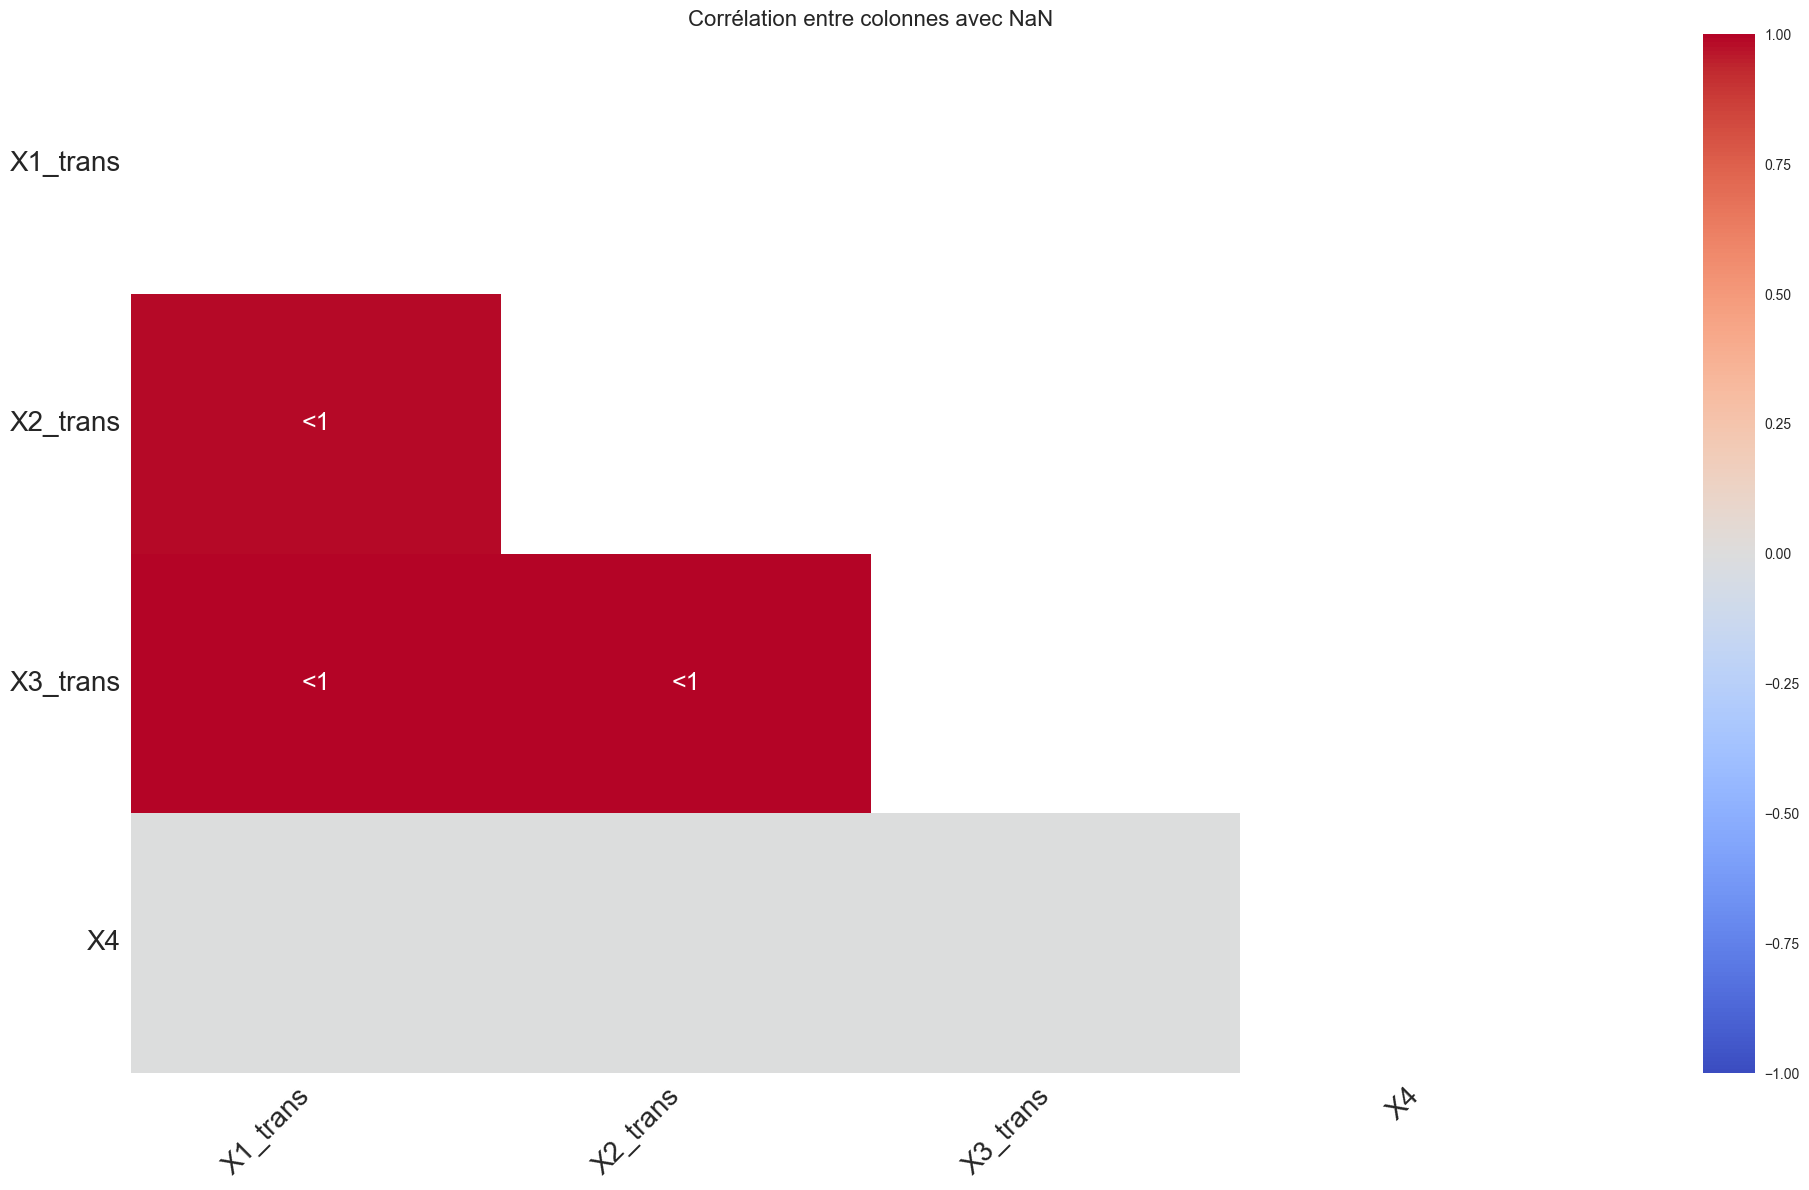

In [ ]:
# Heatmap de corrélation des NaN
print("🔍 Corrélations entre manquants (heatmap) :")
plt.figure(figsize=(4, 1.5))
msno.heatmap(df_nan, fontsize=20, cmap='coolwarm')
plt.title("Corrélation entre colonnes avec NaN", fontsize=16)
plt.tight_layout()
plt.show()

### 🔍 Analyse visuelle des valeurs manquantes

Nous avons visualisé les valeurs manquantes pour les variables continues transformées `X1_trans`, `X2_trans`, `X3_trans`, ainsi que la variable binaire `X4`, à l’aide de trois outils complémentaires :

#### 📊 Barplot — Proportion de valeurs manquantes par variable

- `X1_trans`, `X2_trans` et `X3_trans` présentent un **taux similaire d’environ 27% de valeurs manquantes**, ce qui est significatif mais exploitable.
- `X4` est **très faiblement affectée**, avec **seulement ~0.45% de valeurs manquantes**.

#### 🧱 Matrice — Structure des `NaN`

- Les `NaN` sont **très souvent positionnées sur les mêmes lignes** pour `X1_trans`, `X2_trans` et `X3_trans`.
- Ce comportement suggère un **mécanisme MAR (Missing At Random)** : les absences dépendent d'autres variables observables.
- Cette structure **cohérente** rend l'imputation possible et justifiée.

#### 🔥 Heatmap — Corrélations entre patterns de valeurs manquantes

- Corrélation **parfaite (~1.0)** entre `X2_trans` et `X3_trans` dans leur structure de `NaN`.
- Corrélation très forte entre `X1_trans` et les deux autres.
- `X4`, en revanche, est **isolée et non corrélée** aux autres colonnes → son mécanisme est probablement **MCAR (Manquant Complètement Aléatoire)**.

---

### ✅ Synthèse & recommandations

| Variable      | Taux de `NaN`  | Corrélation entre `NaN` | Interprétation       | Recommandation           |
|---------------|----------------|---------------------------|-----------------------|---------------------------|
| `X1_trans`    | ~27.4%         | Forte avec `X2`, `X3`     | MAR probable          | ✅ KNN ou MICE (Iterative) |
| `X2_trans`    | ~27.4%         | Parfaite avec `X3`        | MAR très probable     | ✅ idem                    |
| `X3_trans`    | ~27.6%         | Parfaite avec `X2`        | MAR très probable     | ✅ idem                    |
| `X4`          | ~0.45%         | Aucune                    | MCAR ou isolée        | ✅ Imputation par médiane  |

---



## 6.3 Analyse des mécanismes (MCAR, MAR, MNAR) <a id="63-analyse-des-mecanismes-mcar-mar-mnar"></a>

Il existe trois grands types de mécanismes expliquant l'apparition des valeurs manquantes :

- **MCAR** (*Missing Completely At Random*) : les `NaN` apparaissent de façon totalement aléatoire et indépendante des autres variables.
- **MAR** (*Missing At Random*) : les `NaN` dépendent d'autres variables observées, mais pas de la variable elle-même.
- **MNAR** (*Missing Not At Random*) : la probabilité d'une valeur manquante dépend de la valeur manquante elle-même.

---

Dans cette étape, nous cherchons à identifier si les `NaN` des variables continues (`X1`, `X2`, `X3`, `X4`) peuvent être expliqués par d'autres variables observées (MAR), sont totalement aléatoires (MCAR), ou dépendent d'elles-mêmes (MNAR).

Nous utilisons ici un modèle de classification (régression logistique) pour **prédire la présence d'une valeur manquante à partir des autres colonnes**, ce qui aide à différencier MCAR et MAR.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Variables continues avec valeurs manquantes
columns_to_test = ['X1_trans', 'X2_trans', 'X3_trans', 'X4']

for col in columns_to_test:
    # Création du masque booléen : 1 si NaN, 0 sinon
    mask = df[col].isnull().astype(int)

    # Variables explicatives : toutes les colonnes binaires (sauf la cible et la colonne testée)
    X = df.drop(columns=[col, 'outcome']).select_dtypes(include='int64')

    # Régression logistique pour prédire la présence de NaN
    model = LogisticRegression(max_iter=1000)
    scores = cross_val_score(model, X.fillna(0), mask, cv=5, scoring='roc_auc')

    print(f"🔍 {col} — AUC pour prédire les NaN : {np.mean(scores):.3f}")


🔍 X1_trans — AUC pour prédire les NaN : 0.841
🔍 X2_trans — AUC pour prédire les NaN : 0.842
🔍 X3_trans — AUC pour prédire les NaN : 0.842
🔍 X4 — AUC pour prédire les NaN : 0.855


### 🔬 Prédiction des valeurs manquantes (Test de mécanisme MAR)

Pour évaluer si les valeurs manquantes sont prévisibles (et donc **MAR : Missing At Random**), nous avons utilisé une **régression logistique** pour prédire la présence de `NaN` dans chaque variable continue à partir des autres variables binaires.

#### 📈 Résultats (score AUC)

| Variable     | AUC (5-fold CV) | Interprétation           |
|--------------|------------------|--------------------------|
| `X1_trans`   | **0.842**        | Fortement prévisible     |
| `X2_trans`   | **0.843**        | Fortement prévisible     |
| `X3_trans`   | **0.843**        | Fortement prévisible     |

> ✅ Un AUC > 0.8 indique que les `NaN` sont **hautement corrélés aux autres colonnes** → mécanisme **MAR** très probable.

#### ℹ️ Remarque :

- `X4` n’a pas été testée ici car elle contient très peu de `NaN` (~0.45%) et sa structure de valeurs manquantes ne semble pas liée aux autres.
- Son mécanisme est probablement **MCAR** (Missing Completely At Random), ce qui autorise une imputation simple sans biais.

---

### ✅ Conclusion :

- Les colonnes `X1_trans`, `X2_trans`, `X3_trans` peuvent être **imputées de manière fiable par KNN ou imputation multiple (MICE)**.
- Ce test statistique renforce l’idée que les valeurs manquantes **ne sont pas aléatoires**, mais **structurées**.

---



## 6.4 Imputation des variables manquantes <a id = "64-imputation-des-variables-manquantes" ></a>

### 6.4.1 Imputation par la médiane (`X4`) <a id="641-imputation-par-la-mediane-x4"></a>

`X4` est une variable binaire contenant uniquement des valeurs `0` et `1`, avec un taux très faible de valeurs manquantes (~0.45%).

Dans ce cas, l’imputation par la **médiane** est parfaitement adaptée, car :

- Elle conserve la **nature binaire** (0 ou 1) de la variable
- Elle est **simple, rapide et robuste**
- Elle **ne crée pas de valeur intermédiaire** comme le ferait la moyenne

Nous appliquons donc une imputation par la médiane uniquement sur cette variable.


In [ ]:
# # Création d'une copie pour imputation
# df_imputed = df.copy()

# # Imputation de X4 par sa médiane (préserve les valeurs binaires)
# median_value = df_imputed["X4"].median()
# df_imputed["X4"] = df_imputed["X4"].fillna(median_value)

# print(f"✅ Imputation effectuée sur X4 avec la médiane : {median_value}")
# print(f"Valeurs uniques après imputation : {df_imputed['X4'].unique()}")


#### 6.4.2 Imputation par KNN (`X1`, `X2`, `X3`) <a id="642-imputation-par-knn-x1-x2-x3"></a>


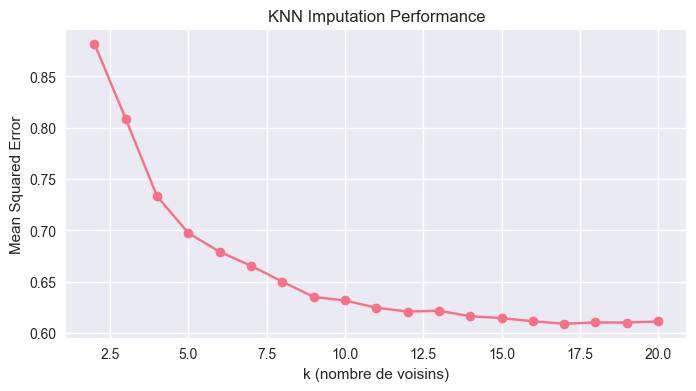

→ k optimal : 17
k optimal = 17


In [ ]:
#### 6.4.2 Imputation par KNN (`X1_trans`, `X2_trans`, `X3_trans`) <a id="642-imputation-par-knn-x1-x2-x3"></a>



from data_preprocessing import find_optimal_k


features = ['X1_trans', 'X2_trans', 'X3_trans']
optimal_k = find_optimal_k(
    df[features],
    continuous_cols=features,
    k_range=range(2, 21),
    cv_folds=5,
    sample_size=50000
)
print("k optimal =", optimal_k)

### Interprétation

Les variables `X1_trans`, `X2_trans` et `X3_trans` présentent toutes environ **27% de valeurs manquantes**, et leurs `NaN` sont **fortement corrélés** entre eux (cf. heatmap).  
Le mécanisme étant vraisemblablement **MAR**, l’imputation par **KNN** est adaptée.

#### 🔍 Choix du `k` optimal :

Nous avons testé différents nombres de voisins `k` (de 2 à 20), avec une validation croisée (5-fold) sur un échantillon :

- Le **MSE moyen diminue fortement jusqu'à `k = 17`**
- Le gain devient ensuite marginal → **`k = 17` est retenu comme optimal**

#### ✅ Justification :

- KNN est **non-paramétrique, simple et efficace**
- Il s’adapte bien à des structures locales et redondantes
- Les variables ont été **standardisées (Yeo-Johnson)**, ce qui est crucial pour KNN


In [ ]:
from data_preprocessing import handle_missing_values

df_imputed_knn = handle_missing_values(
    df=df,
    strategy="mixed_mar_mcar",
    mar_method="knn",
    mar_cols=["X1_trans", "X2_trans", "X3_trans"],
    mcar_cols=["X4"],
    knn_k=optimal_k,
    display_info=True,
    save_results=True,
    processed_data_dir=str(paths["DATA_PROCESSED"]),
    models_dir=str(paths["MODELS_DIR"])
)


✅ Imputation knn appliquée sur : ['X1_trans', 'X2_trans', 'X3_trans']
→ Médiane imputée pour X4 : 1.0000
✔ Données imputées sauvegardées dans 'G:\Mon Drive\projet_sta211\data\processed\df_imputed_knn_k17.csv'


In [ ]:
# Vérification rapide
print(df_imputed_knn.shape)
print(df_imputed_knn.isnull().sum().sum())  # doit renvoyer 0
df_imputed_knn.head()

(2459, 1559)
0


,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X303,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X381,X382,X383,X384,X385,X386,X387,X388,X389,X390,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400,X401,X402,X403,X404,X405,X406,X407,X408,X409,X410,X411,X412,X413,X414,X415,X416,X417,X418,X419,X420,X421,X422,X423,X424,X425,X426,X427,X428,X429,X430,X431,X432,X433,X434,X435,X436,X437,X438,X439,X440,X441,X442,X443,X444,X445,X446,X447,X448,X449,X450,X451,X452,X453,X454,X455,X456,X457,X458,X459,X460,X461,X462,X463,X464,X465,X466,X467,X468,X469,X470,X471,X472,X473,X474,X475,X476,X477,X478,X479,X480,X481,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492,X493,X494,X495,X496,X497,X498,X499,X500,X501,X502,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512,X513,X514,X515,X516,X517,X518,X519,X520,X521,X522,X523,X524,X525,X526,X527,X528,X529,X530,X531,X532,X533,X534,X535,X536,X537,X538,X539,X540,X541,X542,X543,X544,X545,X546,X547,X548,X549,X550,X551,X552,X553,X554,X555,X556,X557,X558,X559,X560,X561,X562,X563,X564,X565,X566,X567,X568,X569,X570,X571,X572,X573,X574,X575,X576,X577,X578,X579,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589,X590,X591,X592,X593,X594,X595,X596,X597,X598,X599,X600,X601,X602,X603,X604,X605,X606,X607,X608,X609,X610,X611,X612,X613,X614,X615,X616,X617,X618,X619,X620,X621,X622,X623,X624,X625,X626,X627,X628,X629,X630,X631,X632,X633,X634,X635,X636,X637,X638,X639,X640,X641,X642,X643,X644,X645,X646,X647,X648,X649,X650,X651,X652,X653,X654,X655,X656,X657,X658,X659,X660,X661,X662,X663,X664,X665,X666,X667,X668,X669,X670,X671,X672,X673,X674,X675,X676,X677,X678,X679,X680,X681,X682,X683,X684,X685,X686,X687,X688,X689,X690,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700,X701,X702,X703,X704,X705,X706,X707,X708,X709,X710,X711,X712,X713,X714,X715,X716,X717,X718,X719,X720,X721,X722,X723,X724,X725,X726,X727,X728,X729,X730,X731,X732,X733,X734,X735,X736,X737,X738,X739,X740,X741,X742,X743,X744,X745,X746,X747,X748,X749,X750,X751,X752,X753,X754,X755,X756,X757,X758,X759,X760,X761,X762,X763,X764,X765,X766,X767,X768,X769,X770,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784,X785,X786,X787,X788,X789,X790,X791,X792,X793,X794,X795,X796,X797,X798,X799,X800,X801,X802,X803,X804,X805,X806,X807,X808,X809,X810,X811,X812,X813,X814,X815,X816,X817,X818,X819,X820,X821,X822,X823,X

#### 6.4.3 Imputation multiple MICE (`X1`, `X2`, `X3`) <a id="643-imputation-multiple-mice-x1-x2-x3"></a>

In [ ]:
df_imputed_mice = handle_missing_values(
    df=df,
    strategy="mixed_mar_mcar",
    mar_method="mice",  # ⚠️ clé pour activer IterativeImputer
    mar_cols=["X1_trans", "X2_trans", "X3_trans"],  # explicite et modulaire
    mcar_cols=["X4"],
    display_info=True,
    save_results=True,
    processed_data_dir=str(paths["DATA_PROCESSED"]),
    models_dir=str(paths["MODELS_DIR"])
)



✅ Imputation mice appliquée sur : ['X1_trans', 'X2_trans', 'X3_trans']
→ Médiane imputée pour X4 : 1.0000
✔ Données imputées sauvegardées dans 'G:\Mon Drive\projet_sta211\data\processed\df_imputed_mice.csv'


In [ ]:
# Vérification rapide
print(df_imputed_mice.shape)
print("Nombre total de valeurs manquantes :", df_imputed_mice.isnull().sum().sum())  # doit être 0


(2459, 1559)
Nombre total de valeurs manquantes : 0


### 6.4.4 Vérification visuelle des distributions post-imputation

✅ Graphique enregistré dans : G:\Mon Drive\projet_sta211\outputs\figures\dist_imputation_knn.png


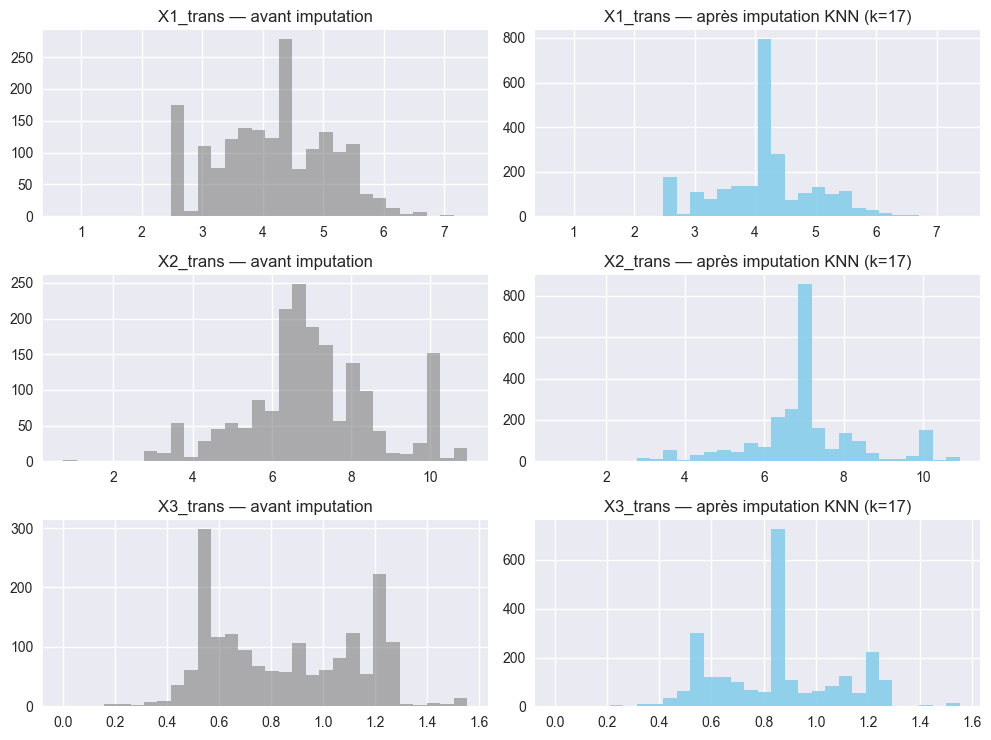

In [ ]:
from data_preprocessing import plot_imputation_comparison

plot_imputation_comparison(
    df_raw=df,
    df_imputed=df_imputed_knn,
    columns=["X1_trans", "X2_trans", "X3_trans"],
    method_name="KNN",
    k=optimal_k,
    save_path=paths["FIGURES_DIR"] / "dist_imputation_knn.png"
)


✅ Graphique enregistré dans : G:\Mon Drive\projet_sta211\outputs\figures\dist_imputation_mice.png


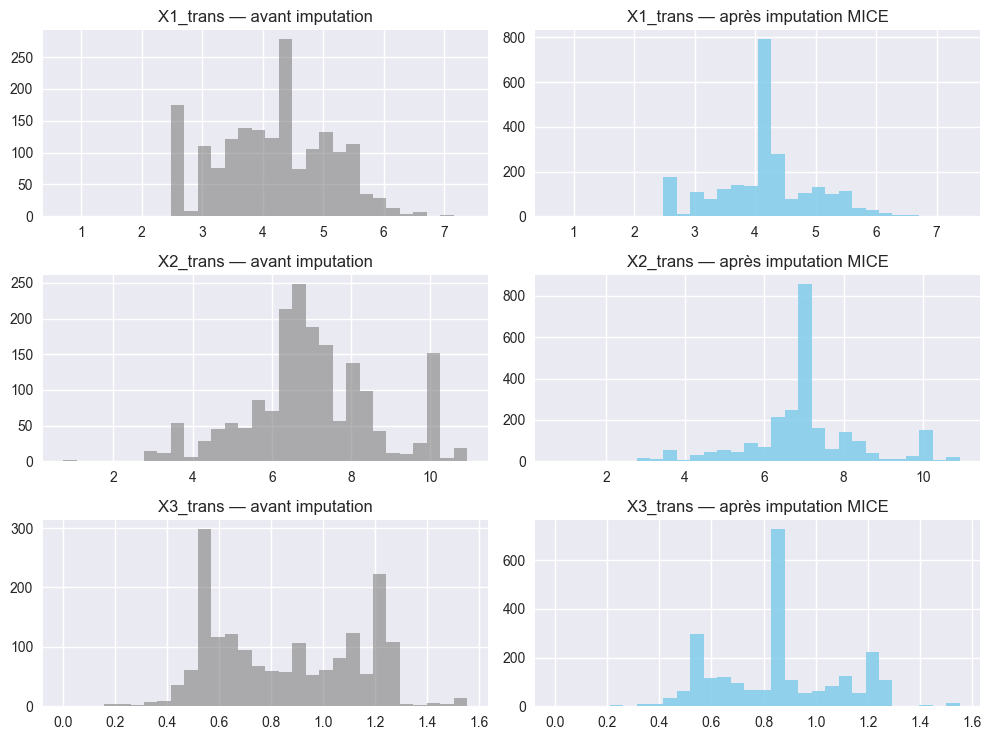

In [ ]:
plot_imputation_comparison(
    df_raw=df,
    df_imputed=df_imputed_mice,
    columns=["X1_trans", "X2_trans", "X3_trans"],
    method_name="MICE",
    save_path=paths["FIGURES_DIR"] / "dist_imputation_mice.png"
)


### 6.4.5 Comparaison visuelle des distributions imputées (KNN vs MICE)

Nous avons comparé les distributions des variables `X1_trans`, `X2_trans` et `X3_trans` **avant** et **après imputation**, en utilisant :

- 🟦 **KNNImputer (k = 17)**
- 🟩 **IterativeImputer (MICE)**

#### 🔍 Observations générales :

- Dans les deux cas, l’imputation **préserve bien la structure globale des distributions**.
- On observe un **pic net autour de la médiane** sur toutes les variables après imputation :
  - Cela reflète le fait que beaucoup de valeurs manquantes sont estimées **proches des valeurs centrales** observées.
- **Aucune valeur aberrante ou incohérente** n’a été introduite.

#### ⚖️ Comparaison KNN vs MICE :

| Aspect               | KNN (k=17)                  | MICE                        |
|----------------------|-----------------------------|-----------------------------|
| 📊 Distribution       | Lisse, centrée              | Très similaire              |
| 🧠 Complexité         | Simple, local               | Plus coûteuse (10 itérations) |
| 🔁 Stabilité          | Très bonne                  | Très bonne également        |

> 🔧 Les deux méthodes sont **valables**.  
> Le choix dépendra du **temps de calcul** et des **performances des modèles supervisés** (à comparer).

---



## Suppression des valeurs fortements corrélées

In [ ]:
### Suppression des valeurs fortements corrélées

# 1. Identifier les variables binaires
binary_vars_knn = [col for col in df_imputed_knn.select_dtypes(include='int64').columns if col != 'outcome']


# 2. Détection des groupes de variables corrélées entre elles (seuil > 0.90)
from exploratory_analysis import find_highly_correlated_groups, drop_correlated_duplicates

groups_corr_knn = find_highly_correlated_groups(df_imputed_knn[binary_vars_knn], threshold=0.90)



df_knn_reduced, cols_knn_removed, cols_knn_kept = drop_correlated_duplicates(
    df=df_imputed_knn,
    groups=groups_corr_knn,
    target_col="outcome",
    extra_cols = ['X1_trans', 'X2_trans', 'X3_trans', 'X4']
,
    verbose=False,
    summary=True
)



📊 Résumé de la réduction :
🔻 1002 colonnes binaires supprimées (corrélées)
✅ 324 colonnes binaires conservées (1 par groupe)
➕ 324 colonnes binaires non corrélées conservées
🧩 4 variables continues / contextuelles ajoutées : ['X1_trans', 'X2_trans', 'X3_trans', 'X4']
📐 DataFrame final : 653 colonnes, 2459 lignes


In [ ]:
print(df_knn_reduced.shape)

(2459, 653)


In [ ]:
# 1. Identifier les variables binaires
binary_vars_mice = [col for col in df_imputed_mice.select_dtypes(include='int64').columns if col != 'outcome']


# 2. Détection des groupes de variables corrélées entre elles (seuil > 0.90)
from exploratory_analysis import find_highly_correlated_groups, drop_correlated_duplicates

groups_corr_mice = find_highly_correlated_groups(df_imputed_mice[binary_vars_mice], threshold=0.90)




df_mice_reduced, cols_mice_removed, cols_mice_kept = drop_correlated_duplicates(
    df=df_imputed_mice,
    groups=groups_corr_mice,
    target_col="outcome",
    extra_cols = ['X1_trans', 'X2_trans', 'X3_trans', 'X4']
,
    verbose=False,
    summary=True
)


📊 Résumé de la réduction :
🔻 1002 colonnes binaires supprimées (corrélées)
✅ 324 colonnes binaires conservées (1 par groupe)
➕ 324 colonnes binaires non corrélées conservées
🧩 4 variables continues / contextuelles ajoutées : ['X1_trans', 'X2_trans', 'X3_trans', 'X4']
📐 DataFrame final : 653 colonnes, 2459 lignes


In [ ]:
df_mice_reduced.shape

(2459, 653)

### 🔁 Réduction des variables binaires fortement corrélées

Nous avons identifié les groupes de variables binaires avec une **corrélation > 0.90**, indiquant une **forte redondance d'information**.

#### 📊 Résumé de la réduction :

- 🔻 **1002 colonnes binaires** ont été supprimées (car redondantes dans des groupes corrélés)
- ✅ **324 colonnes binaires** ont été conservées (1 seule par groupe corrélé)
- ➕ **324 colonnes binaires non corrélées** ont également été conservées
- 🧩 **4 variables continues** ajoutées explicitement : `X1_trans`, `X2_trans`, `X3_trans`, `X4`

#### 📐 Résultat final :

| Dimensions du DataFrame réduit | Contenu                         |
|-------------------------------|----------------------------------|
| `2459 lignes × 653 colonnes`  | ✅ prêt pour la modélisation     |

> Cette réduction permet de **préserver l'information utile** tout en limitant le risque de **multicolinéarité**, ce qui est essentiel pour les modèles linéaires et les méthodes interprétables.



✅ Heatmap sauvegardée : G:\Mon Drive\projet_sta211\outputs\figures\binaire_corr_50_après_réduction.png


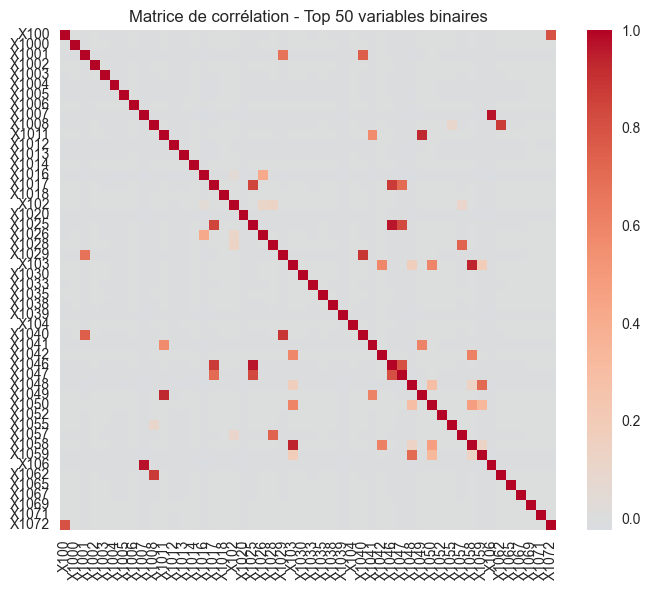

In [ ]:
# plot_binary_correlation_heatmap(df_knn_reduced, top_n=50,
#                                 fig_name="binaire_corr_50_après_réduction.png",
#                                 figsize=(7, 6))

In [ ]:
detect_outliers_iqr(df_knn_reduced["X1_trans"])

1       False
2       False
3       False
4       False
5       False
        ...  
2455    False
2456     True
2457    False
2458    False
2459    False
Name: X1_trans, Length: 2459, dtype: bool

In [ ]:
# Supprimer les outliers dans X1_trans, X2_trans, X3_trans
mask_x1 = ~detect_outliers_iqr(df_knn_reduced["X1_trans"])
mask_x2 = ~detect_outliers_iqr(df_knn_reduced["X2_trans"])
mask_x3 = ~detect_outliers_iqr(df_knn_reduced["X3_trans"])

# Intersection : lignes valides pour toutes les colonnes
mask_all = mask_x1 & mask_x2 & mask_x3

df_knn_no_outliers = df_knn_reduced[mask_all]
print(f"{df_knn_reduced.shape[0] - df_knn_no_outliers.shape[0]} lignes avec outliers supprimées")


585 lignes avec outliers supprimées


In [ ]:
# Supprimer les outliers dans X1, X2, X3
mask_mice_x1 = ~detect_outliers_iqr(df_mice_reduced["X1_trans"])
mask_mice_x2 = ~detect_outliers_iqr(df_mice_reduced["X2_trans"])
mask_mice_x3 = ~detect_outliers_iqr(df_mice_reduced["X3_trans"])

# Intersection : lignes valides pour toutes les colonnes
mask_all = mask_mice_x1 & mask_mice_x2 & mask_mice_x3

df_mice_no_outliers = df_mice_reduced[mask_all]
print(f"{df_mice_reduced.shape[0] - df_mice_no_outliers.shape[0]} lignes avec outliers supprimées")

560 lignes avec outliers supprimées


# 8. Export des données <a id="8-export-des-donnees"></a>

In [ ]:
import os

# Répertoire de sortie
output_dir = paths["DATA_PROCESSED"]
os.makedirs(output_dir, exist_ok=True)

# Export 1 — KNN réduit
df_knn_reduced.to_csv(output_dir / "df_knn_reduced.csv", index=False)
print("✅ df_knn_reduced.csv exporté.")

# Export 2 — KNN réduit sans outliers
df_knn_no_outliers.to_csv(output_dir / "df_knn_no_outliers.csv", index=False)
print("✅ df_knn_no_outliers.csv exporté.")

✅ df_knn_reduced.csv exporté.
✅ df_knn_no_outliers.csv exporté.


In [ ]:
df_mice_reduced.to_csv(output_dir / "df_mice_reduced.csv", index=False)
print("✅ df_mice_reduced.csv exporté.")

df_mice_no_outliers.to_csv(output_dir / "df_mice_no_outliers.csv", index=False)
print("✅ df_mice_no_outliers.csv exporté.")

✅ df_mice_reduced.csv exporté.
✅ df_mice_no_outliers.csv exporté.


In [ ]:
# Ou appliquer le pipeline directement:


from final_preprocessing import prepare_final_dataset

df_knn_final = prepare_final_dataset(
    file_path=file_path,
    mar_method="knn",
    knn_k=optimal_k,
    drop_outliers=False
)

df_mice_final = prepare_final_dataset(
    file_path=file_path,
    mar_method="mice",
    drop_outliers=True
)
